In [ ]:
import pandas as pd
import numpy as np

admission_file = '../ADMISSIONS.csv'
admission_df = pd.read_csv(admission_file)

admission_df.ADMITTIME = pd.to_datetime(admission_df.ADMITTIME,format='%Y-%m-%d %H:%M:%S',errors='coerce')
admission_df.DISCHTIME = pd.to_datetime(admission_df.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admission_df.DEATHTIME = pd.to_datetime(admission_df.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

admission_df = admission_df.sort_values(['SUBJECT_ID','ADMITTIME'])
admission_df = admission_df.reset_index(drop=True)
admission_df['NEXT_ADMITTIME'] = admission_df.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
admission_df['NEXT_ADMISSION_TYPE'] = admission_df.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

rows = admission_df.NEXT_ADMISSION_TYPE=='ELECTIVE'
admission_df.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
admission_df.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

admission_df = admission_df.sort_values(['SUBJECT_ID','ADMITTIME'])

admission_df[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admission_df.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method='bfill')
admission_df['DAYS_NEXT_ADMIT'] = (admission_df.NEXT_ADMITTIME-admission_df.DISCHTIME).dt.total_seconds()/(24*60*60)
admission_df['OUTPUT_LABEL'] = (admission_df.DAYS_NEXT_ADMIT<30).astype('int')
admission_df = admission_df[admission_df['ADMISSION_TYPE']!='NEWBORN']
admission_df = admission_df[admission_df.DEATHTIME.isnull()]
admission_df['DURATION'] = (admission_df['DISCHTIME']-admission_df['ADMITTIME']).dt.total_seconds()/(24*60*60)


In [ ]:
note_file  = '../NOTEEVENTS/NOTEEVENTS.csv'
note_df = pd.read_csv(note_file).sort_values(by=['SUBJECT_ID','HADM_ID','CHARTDATE'])
admission_note_df = pd.merge(admission_df[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME','OUTPUT_LABEL','DURATION']],note_df[['SUBJECT_ID','HADM_ID','CHARTDATE','TEXT','CATEGORY']],on=['SUBJECT_ID','HADM_ID'],how='left')

admission_note_df['ADMITTIME_C'] =  admission_note_df.ADMITTIME.apply(lambda x:str(x).split(' ')[0])
admission_note_df['ADMITTIME_C'] = pd.to_datetime(admission_note_df.ADMITTIME_C,format='%Y-%m-%d',errors='coerce')
admission_note_df['CHARTDATE'] = pd.to_datetime(admission_note_df.CHARTDATE,format='%Y-%m-%d',errors='coerce')

discharge_df = admission_note_df[admission_note_df['CATEGORY']=='Discharge summary']
discharge_df = (discharge_df.groupby(['SUBJECT_ID','HADM_ID'])).nth(-1).reset_index()
discharge_df = discharge_df[discharge_df['TEXT'].notnull()]

def less_n_days_data(admission_note_df,n):
    df_less_n = admission_note_df[((admission_note_df['CHARTDATE']-admission_note_df['ADMITTIME_C']).dt.total_seconds()/(24*60*60))<n]
    df_less_n = df_less_n[df_less_n['TEXT'].notnull()]
    df_concat = pd.DataFrame(df_less_n.groupby('HADM_ID')['TEXT'].apply(lambda x:'%s'%' '.join(x))).reset_index()
    df_concat['OUTPUT_LABEL'] = df_concat['HADM_ID'].apply(lambda x:df_less_n[df_less_n['HADM_ID']==x].OUTPUT_LABEL.values[0])
    return df_concat

df_less_2 = less_n_days_data(admission_note_df,2)
df_less_3 = less_n_days_data(admission_note_df,3)

In [ ]:
import re
def preprocess1(x):
    y = re.sub('\\[(.*?)\\]','',x)
    y = re.sub('[0-9]+\.','',y)
    y = re.sub('dr\.','doctor',y)
    y = re.sub('m\.d\.','md',y)
    y = re.sub('admission date:','',y)
    y = re.sub('discharge date:','',y)
    y = re.sub('--|__|==','',y)
    return y

def preprocessing(df_less_n):
    df_less_n['TEXT'] = df_less_n['TEXT'].fillna(' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\n',' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\r',' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].apply(str.strip)
    df_less_n['TEXT'] = df_less_n['TEXT'].str.lower()
    
    df_less_n['TEXT'] = df_less_n['TEXT'].apply(lambda x:preprocess1(x))
    
    from tqdm import tqdm
    df_len = len(df_less_n)
    want = pd.DataFrame({'ID':[],'TEXT':[],'LABEL':[]})
    for i in tqdm(range(df_len)):
        x=df_less_n.TEXT.iloc[i].split()
        n = int(len(x)/318)
        for j in range(n):
            want = want.append({'TEXT':' '.join(x[j*318:(j+1)*318]),'Label':df_less_n.OUTPUT_LABEL.iloc[i],'ID':df_less_n.HADM_ID.iloc[i]},ignore_index=True)
            if len(x)%318>10:
                want = want.append({'TEXT':' '.join(x[-(len(x)%318):]),'Label':df_less_n.OUTPUT_LABEL.iloc[i],'ID':df_less_n.HADM_ID.iloc[i]},ignore_index=True)
    return want
print(discharge_df.columns)
discharge_df = preprocessing(discharge_df)
df_less_2 = preprocessing(df_less_2)
df_less_3 = preprocessing(df_less_3)
    

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DAYS_NEXT_ADMIT',
       'NEXT_ADMITTIME', 'ADMISSION_TYPE', 'DEATHTIME', 'OUTPUT_LABEL',
       'DURATION', 'CHARTDATE', 'TEXT', 'CATEGORY', 'ADMITTIME_C'],
      dtype='object')


 47%|████▋     | 20652/44112 [41:28<4:06:47,  1.58it/s]

KeyboardInterrupt: 

V3000    0.060513
41401    0.059360
V3001    0.046785
0389     0.035110
41071    0.029714
           ...   
1726     0.000017
8739     0.000017
79001    0.000017
3483     0.000017
74749    0.000017
Name: ICD9_CODE, Length: 2789, dtype: float64


In [1]:
"""
ICD-9
"""


def expand_level2():
    level2 = ['001-009', '010-018', '020-027', '030-041', '042', '045-049', '050-059', '060-066', '070-079', '080-088',
              '090-099', '100-104', '110-118', '120-129', '130-136', '137-139', '140-149', '150-159', '160-165',
              '170-176',
              '176', '179-189', '190-199', '200-208', '209', '210-229', '230-234', '235-238', '239', '240-246',
              '249-259',
              '260-269', '270-279', '280-289', '290-294', '295-299', '300-316', '317-319', '320-327', '330-337', '338',
              '339', '340-349', '350-359', '360-379', '380-389', '390-392', '393-398', '401-405', '410-414', '415-417',
              '420-429', '430-438', '440-449', '451-459', '460-466', '470-478', '480-488', '490-496', '500-508',
              '510-519',
              '520-529', '530-539', '540-543', '550-553', '555-558', '560-569', '570-579', '580-589', '590-599',
              '600-608',
              '610-611', '614-616', '617-629', '630-639', '640-649', '650-659', '660-669', '670-677', '678-679',
              '680-686',
              '690-698', '700-709', '710-719', '720-724', '725-729', '730-739', '740-759', '760-763', '764-779',
              '780-789',
              '790-796', '797-799', '800-804', '805-809', '810-819', '820-829', '830-839', '840-848', '850-854',
              '860-869',
              '870-879', '880-887', '890-897', '900-904', '905-909', '910-919', '920-924', '925-929', '930-939',
              '940-949',
              '950-957', '958-959', '960-979', '980-989', '990-995', '996-999', 'V01-V91', 'V01-V09', 'V10-V19',
              'V20-V29',
              'V30-V39', 'V40-V49', 'V50-V59', 'V60-V69', 'V70-V82', 'V83-V84', 'V85', 'V86', 'V87', 'V88', 'V89',
              'V90',
              'V91', 'E000-E899', 'E000', 'E001-E030', 'E800-E807', 'E810-E819', 'E820-E825', 'E826-E829', 'E830-E838',
              'E840-E845', 'E846-E849', 'E850-E858', 'E860-E869', 'E870-E876', 'E878-E879', 'E880-E888', 'E890-E899',
              'E900-E909', 'E910-E915', 'E916-E928', 'E929', 'E930-E949', 'E950-E959', 'E960-E969', 'E970-E978',
              'E980-E989', 'E990-E999']

    level2_expand = {}
    for i in level2:
        tokens = i.split('-')
        if i[0] == 'V':
            if len(tokens) == 1:
                level2_expand[i] = i
            else:
                for j in range(int(tokens[0][1:]), int(tokens[1][1:]) + 1):
                    level2_expand["V%02d" % j] = i
        elif i[0] == 'E':
            if len(tokens) == 1:
                level2_expand[i] = i
            else:
                for j in range(int(tokens[0][1:]), int(tokens[1][1:]) + 1):
                    level2_expand["E%03d" % j] = i
        else:
            if len(tokens) == 1:
                level2_expand[i] = i
            else:
                for j in range(int(tokens[0]), int(tokens[1]) + 1):
                    level2_expand["%03d" % j] = i
    return level2_expand

level3_dict = expand_level2()
def transform_code(unique_code):
    level2 = unique_code[:4] if unique_code[0]=='E' else unique_code[:3]
    level3 = level3_dict[level2]
    
    return [level2,level3]

def build_icd9_tree(unique_codes):
    res = []
    graph_voc = Voc()

    root_node = 'icd9_root'
    level3_dict = expand_level2()
    for code in unique_codes:
        level1 = code
        level2 = level1[:4] if level1[0] == 'E' else level1[:3]
        level3 = level3_dict[level2]
        level4 = root_node

        sample = [level1, level2, level3, level4]

        graph_voc.add_sentence(sample)
        res.append(sample)

    return res, graph_voc


"""
ATC
"""


def build_atc_tree(unique_codes):
    res = []
    graph_voc = Voc()

    root_node = 'atc_root'
    for code in unique_codes:
        sample = [code] + [code[:i] for i in [4, 3, 1]] + [root_node]

        graph_voc.add_sentence(sample)
        res.append(sample)

    return res, graph_voc


In [2]:
import pandas as pd

diag_file = '../DIAGNOSES_ICD.csv'
diagnose_df = pd.read_csv(diag_file)
main_diag_df = diagnose_df[diagnose_df['SEQ_NUM']==1]
main_diag_df['diagnose_level2'],main_diag_df['diagnose_level3'] = zip(*main_diag_df['ICD9_CODE'].apply(transform_code))
print(main_diag_df['diagnose_level2'].value_counts())

V30    6339
414    3576
038    3389
410    3307
424    1721
       ... 
658       1
892       1
V33       1
815       1
696       1
Name: diagnose_level2, Length: 651, dtype: int64


/home/lf/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
import pandas as pd
# count unique number for med2vec
# procedure num: 2710
# diagnose num: 10045
# prescriptions num: 28480
diags_set = set()

def count_pres(proce_df):
    lenp = len(proce_df)
    print(proce_df.columns)
    for i in range(0, lenp):
        drugs = proce_df['NDC'][i]
        # print(proce_df['NDC'][i])
        # drugs = drugs.split(",")
        # for drug in drugs:
        diags_set.add(drugs)


train_admission_df = pd.read_csv('../mimic-iv/PRESCRIPTIONS.csv')

diags_set = set(train_admission_df['NDC'])

# count_pres(train_admission_df)
# count_pres(valid_admission_df)
# count_pres(test_admission_df)


print(len(diags_set))

28480


In [ ]:
# 将icd-10转换为icd-9 PROCEDURES
import pandas as pd

procedure_file = "../mimic-iv/PROCEDURES.csv"
icd_mapping = "../mimic-iv/icd10toicd9.csv"

proce_df = pd.read_csv(procedure_file)
map_file = pd.read_csv(icd_mapping)

maps = {}


lenm = len(map_file)

print(lenm)
for i in range(0, lenm):
    maps[map_file['icd10cm'][i]] = map_file['icd9cm'][i]

# print(maps['2825'])

lenp = len(proce_df)
print(lenp)
print(proce_df.iloc[0][6])
print(proce_df.iloc[0][7])

aa = 0

howa = {}
drops = []

proce_df['ICD9_CODE'] = proce_df['ICD9_CODE'].map(lambda x: maps[x] if maps.get(x, -1) != -1 else x)
proce_df['icd_version'] = proce_df['icd_version'].map(lambda x: 9 if x == 10 else 9)


for i in range(0, lenp):
    if i % 100000 == 0:
        print(i, " completed")
    if proce_df['icd_version'][i] == 10:
        aa = aa + 1
        # code = maps[proce_df['ICD9_CODE'][i]]
        # if maps.get(code, -1) == -1:
        #     aa = aa + 1
        #     drops.append(i)
            # print(code)
            
        # else:
        # cca = maps[]
        # proce_df.iloc[i, 6] = code
        # proce_df.iloc[i, 7] = 9
        # proce_df.loc[i]['ICD9_CODE'] = cca
        # proce_df.loc[i]['icd_version'] = 9
        # proce_df['ICD9_CODE'][i] = cca  
        # proce_df['icd_version'][i] = 9



print(aa)
print(drops)
proce_df = proce_df.drop(index=drops)

proce_df.to_csv("../mimic-iv/PROCEDURES.csv")




161409
771200
7569
9
0  completed
100000  completed
200000  completed
300000  completed
400000  completed
500000  completed
600000  completed
700000  completed
0
[]


In [68]:
# 将icd-10转换为icd-9 DIAGNOSES
import pandas as pd

procedure_file = "../mimic-iv/DIAGNOSES.csv"
icd_mapping = "../mimic-iv/icd10toicd9.csv"

proce_df = pd.read_csv(procedure_file)
map_file = pd.read_csv(icd_mapping)

maps = {}

drops = []

lenm = len(map_file)

print(lenm)
for i in range(0, lenm):
    maps[map_file['icd10cm'][i]] = map_file['icd9cm'][i]

# print(maps['2825'])

lenp = len(proce_df)
print(lenp)

# for i in range(0, lenp):
#     if i % 500000 == 0:
#         print(i, " completed")
#     if proce_df['icd_version'][i] == 10:
#         # aa = aa + 1
#         code = proce_df['ICD9_CODE'][i]
#         if maps.get(code, -1) == -1:
#             aa = aa + 1
#             drops.append(i)
#             # print(code)

# print(aa)
# print(drops)
# proce_df = proce_df.drop(index=drops)
# proce_df.to_csv("../mimic-iv/DIAGNOSES.csv")


aa = 0


# proce_df['ICD9_CODE'] = proce_df['ICD9_CODE'].map(lambda x: maps[x] if maps.get(x, -1) != -1 else x)
# proce_df['icd_version'] = proce_df['icd_version'].map(lambda x: 9 if x == 10 else 9)


for i in range(0, lenp):
    if i % 500000 == 0:
        print(i, " completed")
    if proce_df['ICD9_CODE'][i] == 'Nod':
        aa = aa + 1
        drops.append(i)
    elif proce_df['ICD9_CODE'][i] == 'NoDx':
        aa = aa + 1
        drops.append(i)


print(aa)
print(drops)
proce_df = proce_df.drop(index=drops)

proce_df.to_csv("../mimic-iv/DIAGNOSES.csv")



161409
5220043
0  completed
500000  completed
1000000  completed
1500000  completed
2000000  completed
2500000  completed
3000000  completed
3500000  completed
4000000  completed
4500000  completed
5000000  completed
0
[]


In [85]:

import pandas as pd

icd_mapping = "../mimic-iv/icd10toicd9.csv"
map_file = pd.read_csv(icd_mapping)
new_map = map_file[~(map_file.icd9cm=='999995')]
# print(new_map)
new_map.to_csv("../mimic-iv/icd10toicd9_new.csv", index=None)


# 删除空图

fe = open("../mimic-iv/empty_g.txt", "r")

line = fe.readline()               # 调用文件的 readline()方法 

sete = set()

while line: 
    line = line.replace('\n', '').replace('\r', '')
    sete.add(int(line))
    # print(line, end="")                   # 后面跟 ',' 将忽略换行符 
    line = fe.readline() 
fe.close()

print(len(sete))
sete = list(sete)

# print(sete)

61124


In [104]:
# 将icd-10转换为icd-9 DIAGNOSES 10-16  2021/10/26  无需重复跑
import pandas as pd

print(len(sete))
procedure_file = "../mimic-iv/beifen/PROCEDURES_ICD.csv"
diagnose_file = "../mimic-iv/beifen/DIAGNOSES_ICD.csv"
pres_file = "../mimic-iv/beifen/PRESCRIPTIONS.csv"
adm_file = "../mimic-iv/beifen/ADMISSIONS.csv"
icd_mapping = "../mimic-iv/icd10toicd9_new.csv"


print("start load")

map_file = pd.read_csv(icd_mapping)

lenm = len(map_file)
print(lenm)

maps = {}

for i in range(0, lenm):
    maps[map_file['icd10cm'][i]] = map_file['icd9cm'][i]

lenm = len(maps)

print(lenm)


proce_df = pd.read_csv(procedure_file)
diag_df = pd.read_csv(diagnose_file)
pres_df = pd.read_csv(pres_file,dtype={'NDC':'category'})
adm_df = pd.read_csv(adm_file)

drops = []



lenp = len(proce_df)
lend = len(diag_df)

print(lenp)
aa=0

for i in range(0, lenp):
    if i % 500000 == 0:
        print(i, " completed")
    if proce_df['icd_version'][i] == 10:
        # aa = aa + 1
        code = proce_df['ICD9_CODE'][i]
        if maps.get(code, -1) == -1:
            aa = aa + 1
            drops.append(i)
            # print(code)

for i in range(0, 100):
    print(drops[i])

proce_df = proce_df.drop(index=drops)
# proce_df['ICD9_CODE'] = proce_df['ICD9_CODE'].map(lambda x: maps[x] if maps.get(x, -1) != -1 else x)
# proce_df.to_csv("../mimic-iv/PROCEDURES.csv", index=None)
print(len(drops))
drops = []


for i in range(0, lend):
    if i % 500000 == 0:
        print(i, " completed")
    if diag_df['icd_version'][i] == 10:
        # aa = aa + 1
        code = diag_df['ICD9_CODE'][i]
        if maps.get(code, -1) == -1:
            aa = aa + 1
            drops.append(i)

diag_df = diag_df = diag_df.drop(index=drops)



proce_df['ICD9_CODE'] = proce_df['ICD9_CODE'].map(lambda x: maps[x] if maps.get(x, -1) != -1 else x)
proce_df['icd_version'] = proce_df['icd_version'].map(lambda x: 9 if x == 10 else 9)

diag_df['ICD9_CODE'] = diag_df['ICD9_CODE'].map(lambda x: maps[x] if maps.get(x, -1) != -1 else x )
diag_df['icd_version'] = diag_df['icd_version'].map(lambda x: 9 if x == 10 else 9)



adm_df = adm_df[~adm_df['HADM_ID'].isin(sete)] 
pres_df = pres_df[~pres_df['HADM_ID'].isin(sete)]
diag_df = diag_df[~diag_df['HADM_ID'].isin(sete)]
proce_df = proce_df[~proce_df['HADM_ID'].isin(sete)]



proce_df.to_csv("../mimic-iv/PROCEDURES.csv", index=None)
diag_df.to_csv("../mimic-iv/DIAGNOSES.csv", index=None)
adm_df.to_csv("../mimic-iv/ADMISSIONS.csv", index=None)
pres_df.to_csv("../mimic-iv/PRESCRIPTIONS.csv", index=None)



61124
start load
160750
141093
779625
0  completed
500000  completed
66851
67303
68347
68397
69279
69640
70712
71032
71128
71129
72011
72368
72594
73145
73165
73370
73372
73391
73421
73489
73656
73706
73708
73723
74139
74228
74817
74818
74819
75056
75102
75190
75428
75765
75779
75858
75876
76083
76456
76787
76789
76940
77011
77018
77081
77379
77464
77658
77815
78029
78149
78268
78418
78420
78503
78516
78521
78522
78629
78716
78894
78930
79123
79125
79242
79244
79562
79571
79811
80043
80157
80159
80210
80211
80217
80234
80410
80600
80661
80702
80848
81066
81077
81080
81121
81389
81408
81412
81434
81483
81495
81693
81700
81703
81745
81747
81790
81791
81799
81812
8425
0  completed
500000  completed
1000000  completed
1500000  completed
2000000  completed
2500000  completed
3000000  completed
3500000  completed
4000000  completed
4500000  completed
5000000  completed


In [2]:
# 将icd-10转换为icd-9 DIAGNOSES 10-16  2021/10/26  无需重复跑========================================================================
import pandas as pd

diagnose_file = "../mimic-iv/beifen/DIAGNOSES_ICD.csv"
adm_file = "../mimic-iv/beifen/ADMISSIONS.csv"

diag_df = pd.read_csv(diagnose_file)
adm_df = pd.read_csv(adm_file)

disease_cohorts = ['V3000', 'V3001', '4019', 'V290', '53081', '41401']


print(diag_df.columns)

drops = []

lenp = len(diag_df)

print(lenp)

aa=0

for i in range(0, lenp):
    if i % 500000 == 0:
        print(i, " completed")
    cca = 0
    for dis in disease_cohorts:
        if dis in diag_df['ICD9_CODE'][i]:
            drops.append(diag_df['HADM_ID'])
            break
        else:
            cca = cca + 1
            

print(len(drops))

adm_df = adm_df[adm_df['HADM_ID'].isin(drops)] 
diag_df = diag_df[diag_df['HADM_ID'].isin(drops)]



diag_df.to_csv("../mimic-iv/DIAGNOSES1.csv", index=None)
adm_df.to_csv("../mimic-iv/ADMISSIONS1.csv", index=None)




Index(['SUBJECT_ID', 'HADM_ID', 'seq_num', 'ICD9_CODE', 'icd_version'], dtype='object')
5280351
0  completed
500000  completed
1000000  completed
1500000  completed
2000000  completed
2500000  completed
3000000  completed
3500000  completed
4000000  completed
4500000  completed
5000000  completed
5047397


In [ ]:
print()

In [105]:
import pandas as pd
admission_file = '../mimic-iv/ADMISSIONS.csv'
procedure_file = '../mimic-iv/PROCEDURES.csv'
prescriptions_file = '../mimic-iv/PRESCRIPTIONS.csv'
diagnoses_file = '../mimic-iv/DIAGNOSES.csv'

adm_df = pd.read_csv(admission_file)
proce_df = pd.read_csv(procedure_file)
pres_df = pd.read_csv(prescriptions_file,dtype={'NDC':'category'})
diag_df = pd.read_csv(diagnoses_file)

MIN_CODE_THRESHOLD = 50
MEDIUM_CODE_THRESHOLD = 100
LARGE_CODE_THEESHOLD = 500

#使用阈值限制 统计medical code出现了多次的入院id
def construct_valid_subset(raw_df,column='ICD9_CODE',threshold=MIN_CODE_THRESHOLD,desc='filter desc:'):
    base_df = raw_df[column].value_counts()

    valid_code = base_df[base_df>=threshold].index.values
    print(desc,threshold,len(valid_code))
    filtered_df = raw_df[raw_df[column].isin(valid_code)]
    filtered_admission_ids = set(filtered_df['HADM_ID'].tolist())
#     print(len(filtered_admission_ids))
    return valid_code,filtered_admission_ids,filtered_df

print("start")

diag_codes,diag_admission_ids,diag_df = construct_valid_subset(diag_df,desc='valid diagnoses code base/num: ')
proce_codes,proce_admission_ids,proce_df = construct_valid_subset(proce_df,desc='valid procedure code base/num: ')
pres_codes,pres_admission_ids,pres_df = construct_valid_subset(pres_df,column='NDC',desc='valid prescription code base/num: ')

common_admission_ids = diag_admission_ids & proce_admission_ids & pres_admission_ids

diag_df = diag_df.groupby(['SUBJECT_ID','HADM_ID']).agg({'ICD9_CODE':lambda x:','.join(x)}).reset_index().rename(columns={'ICD9_CODE':'ICD9_DIAG'})
common_diag_df = diag_df[diag_df['HADM_ID'].isin(common_admission_ids)]

proce_df.ICD9_CODE = proce_df.ICD9_CODE.astype(str)
proce_df = proce_df.groupby(['SUBJECT_ID','HADM_ID']).agg({'ICD9_CODE':lambda x:','.join(x)}).reset_index().rename(columns={'ICD9_CODE':'ICD9_PROCE'})

pres_df.drop(index=pres_df[pres_df['NDC'] == '0'].index, axis=0, inplace=True)
pres_df = pres_df.groupby(['SUBJECT_ID','HADM_ID']).agg({'NDC':lambda x:','.join(x)}).reset_index()


common_df = pd.merge(common_diag_df,proce_df,on=['SUBJECT_ID','HADM_ID'])
common_df = pd.merge(common_df,pres_df,on=['SUBJECT_ID','HADM_ID'])
print("end")

start
valid diagnoses code base/num:  50 3575
valid procedure code base/num:  50 941
valid prescription code base/num:  50 3705
end


In [106]:
'''
    for each admission, category it to only single visit or the visit can be formulated in a visit sequence
'''
print('patient statics: ')
print(len(common_df.SUBJECT_ID.unique()))

visit_num_df = common_df[['SUBJECT_ID','HADM_ID']].groupby('SUBJECT_ID').HADM_ID.unique().reset_index()
visit_num_df['HADM_ID_LEN'] = visit_num_df['HADM_ID'].apply(lambda x:len(x))
multi_subjects = visit_num_df[visit_num_df['HADM_ID_LEN']>1].SUBJECT_ID.unique()
print(len(multi_subjects),' patient has multi visits')
single_subjects = visit_num_df[visit_num_df['HADM_ID_LEN']==1].SUBJECT_ID.unique()
print(len(single_subjects),' patient has single visits')

print('admission statics:')
print(len(common_df.HADM_ID.unique()))
common_multi_df = common_df[common_df['SUBJECT_ID'].isin(multi_subjects)]
print(len(common_multi_df),' admission can be formulate as a visit sequence')
common_single_df = common_df[common_df['SUBJECT_ID'].isin(single_subjects)]
print(len(common_single_df),' admission are single visits')


patient statics: 
97432
42824  patient has multi visits
54608  patient has single visits
admission statics:
200270
145662  admission can be formulate as a visit sequence
54608  admission are single visits


In [107]:
# common_single_df['ICD9_DIAG_CNT'] = common_single_df['ICD9_DIAG'].apply(lambda x:len(x.split(',')))
# print(len(common_single_df))
# common_single_onediag_df = common_single_df[common_single_df['ICD9_DIAG_CNT']==1]
# print(len(common_single_onediag_df))
# common_single_df['common_df'] = common_single_df['ICD9_CODE'].apply(lambda x:len(x))
# print(common_single_df.head())
# single_disease_df = diag_df[diag_df['']]

In [108]:
print(common_df.columns)

Index(['SUBJECT_ID', 'HADM_ID', 'ICD9_DIAG', 'ICD9_PROCE', 'NDC'], dtype='object')


In [109]:
'''
    construct all the knowledge graph with PMI value
    the entity type: diagnose, procedure, prescription
    the relation type: diagnose-procedure, diagnose-prescription, procedure-presciption
'''
from math import log

def construct_ent_pairs(x,head_col,tail_col,all_pairs):
    for head_ent in x[head_col].split(','):
        for tail_ent in x[tail_col].split(','):
            all_pairs.append(head_ent+','+tail_ent)
            

'''
    based on the valid pmi value, construct the relation
'''
def construct_relation(common_df,head_col,tail_col):
    all_pairs = []
    common_df.apply(construct_ent_pairs,axis=1,args=(head_col,tail_col,all_pairs))
#     print(len(all_pairs))
    entity_freq = {}
    rel_pair_count = {}
    for rel_pair in all_pairs:
        head_ent,tail_ent = rel_pair.split(',')
        if rel_pair not in rel_pair_count:
            rel_pair_count[rel_pair] = 1
        else:
            rel_pair_count[rel_pair]+=1
        if head_ent not in entity_freq:
            entity_freq[head_ent] = 1
        else:
            entity_freq[head_ent]+=1
        if tail_ent not in entity_freq:
            entity_freq[tail_ent] = 1
        else:
            entity_freq[tail_ent]+=1
    
    num_windows = len(all_pairs)
    pmi_result = []
    for rel_pair in rel_pair_count:
        entities = rel_pair.split(',')
        pmi = log((1.0*rel_pair_count[rel_pair]/num_windows)/(1.0*entity_freq[entities[0]]*entity_freq[entities[1]]/(num_windows*num_windows)))
        if pmi<0:continue
        pmi_result.append([entities[0],entities[1],pmi])
    return pmi_result

def write_relation(pmi_result,output_file):
    with open(output_file,'w',encoding='utf-8') as writer:
        writer.write('head ent'+'\t'+'tail ent'+'\t'+'pmi\n')
        for key in pmi_result:
            writer.write(key[0]+'\t'+key[1]+'\t'+str(key[2])+'\n')
    print('relation file writing done...')
         

diag_proce_rel = construct_relation(common_df,'ICD9_DIAG','ICD9_PROCE')
print('diagnose and procedure relation num: ',len(diag_proce_rel))
write_relation(diag_proce_rel,'../self_kg/diag_proce_rel.csv')

diag_pres_rel = construct_relation(common_df,'ICD9_DIAG','NDC')
print('diagnose and prescription relation num: ',len(diag_pres_rel))
write_relation(diag_pres_rel,'../self_kg/diag_pres_rel.csv')

proce_pres_rel = construct_relation(common_df,'ICD9_PROCE','NDC')
print('procedure and presciption relation num: ',len(proce_pres_rel))
write_relation(proce_pres_rel,'../self_kg/proce_pres_rel.csv')

diagnose and procedure relation num:  439465
relation file writing done...
diagnose and prescription relation num:  2369432
relation file writing done...
procedure and presciption relation num:  602296
relation file writing done...


In [110]:
'''
    split all the visits into the train, valid, test dataset respectively
'''
import random,math
single_admission_nums = len(common_single_df)

#split all admissions into train,valid and test with ratio 0.6,0.2,0.2
train_bound,valid_bound = math.floor(0.6*single_admission_nums),math.floor(0.8*single_admission_nums)
all_admission_ids = common_single_df.HADM_ID.unique()

random.shuffle(all_admission_ids)
train_admission_ids = all_admission_ids[:train_bound]
valid_admission_ids = all_admission_ids[train_bound:valid_bound]
test_admission_ids = all_admission_ids[valid_bound:]
assert single_admission_nums==len(train_admission_ids)+len(valid_admission_ids)+len(test_admission_ids)

train_admission_df = common_single_df[common_single_df['HADM_ID'].isin(train_admission_ids)]
valid_admission_df = common_single_df[common_single_df['HADM_ID'].isin(valid_admission_ids)]
test_admission_df = common_single_df[common_single_df['HADM_ID'].isin(test_admission_ids)]

train_admission_df['disease'] = train_admission_df['ICD9_DIAG'].apply(lambda x:x.split(',')[0])
train_admission_df.to_csv('../self_dataset/train_admissions.csv',index=False)

valid_admission_df['disease'] = valid_admission_df['ICD9_DIAG'].apply(lambda x:x.split(',')[0])
valid_admission_df.to_csv('../self_dataset/valid_admissions.csv',index=False)

test_admission_df['disease'] = test_admission_df['ICD9_DIAG'].apply(lambda x:x.split(',')[0])
test_admission_df.to_csv('../self_dataset/test_admissions.csv',index=False)

print(len(train_admission_df),len(valid_admission_df),len(test_admission_df))

print("end")

32764 10922 10922
end


In [111]:
def construct_labels(test_admission_df,label_file):
#     test_admission_df = pd.read_csv(admission_file)
    
    similar_pairs,dis_similar_pairs,disease_hadm_ids = [],[],{}
    by_disease_df = test_admission_df.groupby('disease')['HADM_ID'].unique().reset_index()
    all_hadm_ids = test_admission_df['HADM_ID'].tolist()
    for disease,hadm_ids in  zip(by_disease_df['disease'],by_disease_df['HADM_ID']):
        if len(hadm_ids)==1:continue
        hadm_ids = hadm_ids.tolist()
        for admission_id in hadm_ids:
            similar_pairs.append((admission_id,random.choice(hadm_ids)))
            other_hadm_ids = random.sample(list(set(all_hadm_ids)-set(hadm_ids)),1)
            for o_admission_id in other_hadm_ids:
                dis_similar_pairs.append((admission_id,o_admission_id))
                
    print('construct labels with similar and dissimilar counts: ',len(similar_pairs),len(dis_similar_pairs))            
    with open(label_file,'w',encoding='utf-8') as writer:
        writer.write('hadm_id\t'+'hadm_id\t'+'label\n')
        for similar_pair,dis_similar_pair in zip(similar_pairs,dis_similar_pairs):
            writer.write(str(similar_pair[0])+'\t'+str(similar_pair[1])+'\t'+'1\n')
            writer.write(str(dis_similar_pair[0])+'\t'+str(dis_similar_pair[1])+'\t'+'0\n')
    return similar_pairs,dis_similar_pairs

construct_labels(train_admission_df,'../self_dataset/train_label.csv')
construct_labels(valid_admission_df,'../self_dataset/valid_label.csv')
construct_labels(test_admission_df,'../self_dataset/test_label.csv')

print("end")
       

# def construct_labels(admission_file):
#     admission_df = pd.read_csv(admission_file)
#     admission_df.groupby('disease')

construct labels with similar and dissimilar counts:  32037 32037
construct labels with similar and dissimilar counts:  10242 10242
construct labels with similar and dissimilar counts:  10236 10236
end


In [112]:
import pandas as pd
import random
import numpy as np
test_admission_df = pd.read_csv('../self_dataset/test_admissions.csv')
def construct_labels(test_admission_df,label_file):
#     test_admission_df = pd.read_csv(admission_file)
    
    similar_pairs,dis_similar_pairs,disease_hadm_ids = [],[],{}
    by_disease_df = test_admission_df.groupby('disease')['HADM_ID'].unique().reset_index()
    all_hadm_ids = test_admission_df['HADM_ID'].tolist()
    for disease,hadm_ids in  zip(by_disease_df['disease'],by_disease_df['HADM_ID']):
        if len(hadm_ids)==1:continue
        hadm_ids = hadm_ids.tolist()
        for admission_id in hadm_ids:
            similar_pairs.append((admission_id,random.choice(hadm_ids)))
            other_hadm_ids = random.sample(list(set(all_hadm_ids)-set(hadm_ids)),1)
            for o_admission_id in other_hadm_ids:
                dis_similar_pairs.append((admission_id,o_admission_id))
                
    print('construct labels with similar and dissimilar counts: ',len(similar_pairs),len(dis_similar_pairs))            
    with open(label_file,'w',encoding='utf-8') as writer:
        writer.write('hadm_id\t'+'hadm_id\t'+'label\n')
        for similar_pair,dis_similar_pair in zip(similar_pairs,dis_similar_pairs):
            writer.write(str(similar_pair[0])+'\t'+str(similar_pair[1])+'\t'+'1\n')
            writer.write(str(dis_similar_pair[0])+'\t'+str(dis_similar_pair[1])+'\t'+'0\n')
    return similar_pairs,dis_similar_pairs
# construct_labels(test_admission_df,'../self_dataset/test_label.csv')
test_hadm_ids = test_admission_df['HADM_ID'].values
test_diseases = list(set(test_admission_df['disease'].values))

for idx, row in test_admission_df.iterrows():
    print(test_diseases.index(row['disease']))
    break
#cohorts 每个病人对应的cohorts编号
# left_ids, right_ids, aff_mat, cohorts = [], [], np.ones((len(test_hadm_ids),len(test_hadm_ids))), []
# for i in range(len(test_hadm_ids)):
#     for j in range(i+1,len(test_hadm_ids)):
#         aff_mat[i][j] = 0
#         aff_mat[j][i] = 0
#     cohorts.append(test_diseases.index( test_admission_df.loc[i,'disease']))

# print(test_admission_df.head())

10


In [113]:
import pandas as pd
import random
test_admission_df = pd.read_csv('../self_dataset/test_admissions.csv')
similar_disease, other_disease = ['410','411','412','413','414'], []
high_fre_disease = '41401'
for sim_dis in similar_disease:
    for dis in list(set(test_admission_df['disease'])):#groupby('disease').size().reset_index(name='count').sort_values(['count'],ascending=False
        if dis.startswith(sim_dis) and dis!=high_fre_disease:
            other_disease.append(dis)

# other_disease = ['41402','41011','41189']
chosen_admission_df = test_admission_df[test_admission_df['disease']==high_fre_disease]
close_chosen_admission_df = test_admission_df[test_admission_df.disease.isin(other_disease)]
other_disease.append(high_fre_disease)
not_chosen_admission_df = test_admission_df[~test_admission_df.disease.isin(other_disease)]
assert len(test_admission_df) == len(chosen_admission_df)+len(not_chosen_admission_df)+len(close_chosen_admission_df)

import random
admissions = random.sample(range(len(chosen_admission_df)),4)
base_df = chosen_admission_df.iloc[admissions,:]
close_admissions = random.sample(range(len(close_chosen_admission_df)),2)
close_df = close_chosen_admission_df.iloc[close_admissions,:]
not_admissions = random.sample(range(len(not_chosen_admission_df)),5)
other_df = not_chosen_admission_df.iloc[not_admissions,:]
all_df = pd.concat([base_df,close_df,other_df])

all_df.to_csv('../self_dataset/query_case.csv',index=False)
print("end")

# def construct_labels(test_admission_df,label_file):
# #     test_admission_df = pd.read_csv(admission_file)
    
#     similar_pairs,dis_similar_pairs,disease_hadm_ids = [],[],{}
#     by_disease_df = test_admission_df.groupby('disease')['HADM_ID'].unique().reset_index()
#     all_hadm_ids = test_admission_df['HADM_ID'].tolist()
#     for disease,hadm_ids in  zip(by_disease_df['disease'],by_disease_df['HADM_ID']):
#         if len(hadm_ids)==1:continue
#         hadm_ids = hadm_ids.tolist()
#         for admission_id in hadm_ids:
#             similar_pairs.append((admission_id,random.choice(hadm_ids)))
#             other_hadm_ids = random.sample(list(set(all_hadm_ids)-set(hadm_ids)),1)
#             for o_admission_id in other_hadm_ids:
#                 dis_similar_pairs.append((admission_id,o_admission_id))
                
#     print('construct labels with similar and dissimilar counts: ',len(similar_pairs),len(dis_similar_pairs))            
#     with open(label_file,'w',encoding='utf-8') as writer:
#         writer.write('hadm_id\t'+'hadm_id\t'+'label\n')
#         for similar_pair,dis_similar_pair in zip(similar_pairs,dis_similar_pairs):
#             writer.write(str(similar_pair[0])+'\t'+str(similar_pair[1])+'\t'+'1\n')
#             writer.write(str(dis_similar_pair[0])+'\t'+str(dis_similar_pair[1])+'\t'+'0\n')
#     return similar_pairs,dis_similar_pairs
# construct_labels(test_admission_df,'../self_dataset/test_label.csv') 

end


In [114]:
import pandas as pd

ehr_file = '../self_dataset/query_case.csv'
ehr_df = pd.read_csv(ehr_file)
left_ehr_ids = ehr_df.loc[0,'HADM_ID']
right_ehr_ids = ehr_df.loc[1:,'HADM_ID'].values
print([left_ehr_ids]*len(right_ehr_ids))
print(list(right_ehr_ids))

[29067189, 29067189, 29067189, 29067189, 29067189, 29067189, 29067189, 29067189, 29067189, 29067189]
[29743975, 29508445, 27095885, 21319345, 25574101, 20487558, 26089332, 20444971, 24206585, 26884150]


In [115]:
'''
    construct drug desciptions for image retrieval
'''
pres_df = pd.read_csv('../mimic-iv/PRESCRIPTIONS.csv',dtype={'NDC':'category'})[['NDC','DRUG']]
print(pres_df.columns)
pres_df = pres_df.dropna()
pres_df = pres_df.drop_duplicates().groupby('NDC').first().reset_index()
pres_df.to_csv('../D_NDC_PRESCRIPTIONS.csv',index=False)

Index(['NDC', 'DRUG'], dtype='object')


In [116]:
pres_df = pd.read_csv('../mimic-iv/PRESCRIPTIONS.csv')
print(pres_df.columns)

Index(['SUBJECT_ID', 'HADM_ID', 'pharmacy_id', 'starttime', 'stoptime',
       'drug_type', 'DRUG', 'gsn', 'NDC', 'prod_strength', 'form_rx',
       'dose_val_rx', 'dose_unit_rx', 'form_val_disp', 'form_unit_disp',
       'doses_per_24_hrs', 'route'],
      dtype='object')


In [117]:
'''
    transform the NDC to ATC for ontology embedding
'''
import pandas as pd
train_admission_df = pd.read_csv('../self_dataset/train_admissions.csv')
valid_admission_df = pd.read_csv('../self_dataset/valid_admissions.csv')
test_admission_df = pd.read_csv('../self_dataset/test_admissions.csv')

ndc2rxnorm_file = 'ndc_atc/ndc2rxnorm_mapping.txt'

def ndc2atc(pres_df):
    with open(ndc2rxnorm_file,'r') as f:
        ndc2rxnorm = eval(f.read())
    pres_df['ATC'] = pres_df['NDC'].map(lambda x:','.join([ndc2rxnorm[ndc] for ndc in x.split(',')]))
    return pres_df

train_admission_df = ndc2atc(train_admission_df)
train_admission_df.to_csv('../self_dataset/train_admissions.csv',index=False)
valid_admission_df = ndc2atc(valid_admission_df)
valid_admission_df.to_csv('../self_dataset/valid_admissions.csv',index=False)
test_admission_df = ndc2atc(test_admission_df)
test_admission_df.to_csv('../self_dataset/test_admissions.csv',index=False)
print("end")

end


In [118]:
import pickle
import pandas as pd

train_admission_df = pd.read_csv('../self_dataset/train_admissions.csv')
valid_admission_df = pd.read_csv('../self_dataset/valid_admissions.csv')
test_admission_df = pd.read_csv('../self_dataset/test_admissions.csv')

all_admission_df = pd.concat([train_admission_df,valid_admission_df,test_admission_df])
all_diag_codes = []
all_admission_df['ICD9_DIAG'].apply(lambda x:all_diag_codes.extend(x.split(',')))
all_diag_codes = list(set(all_diag_codes))
print(len(all_diag_codes))
# print(all_diag_codes)
all_proce_codes = []
all_admission_df['ICD9_PROCE'].apply(lambda x:all_proce_codes.extend(x.split(',')))
all_proce_codes = list(set(all_proce_codes))
print(len(all_proce_codes))
all_atc_codes = []
all_admission_df['ATC'].apply(lambda x:all_atc_codes.extend(x.split(',')))
all_atc_codes = list(set(all_atc_codes))
print(len(all_atc_codes))
# print(all_atc_codes)

pickle.dump({'diag_codes':all_diag_codes,'proce_codes':all_proce_codes,'atc_codes':all_atc_codes},open('../self_dataset/vocab.pkl','wb'))#1299 406 1544

3516
930
2270


In [119]:
import pandas as pd
rel_dir = '../self_kg/'
diag_proce_df = pd.read_csv(rel_dir+'diag_proce_rel.csv',sep='\t')
diag_pres_df = pd.read_csv(rel_dir+'diag_pres_rel.csv',sep='\t',dtype={'tail ent':str})
proce_pres_df = pd.read_csv(rel_dir+'proce_pres_rel.csv',sep='\t',dtype={'tail ent':str})

ndc2rxnorm_file = 'ndc_atc/ndc2rxnorm_mapping.txt'

# ndc2rxnorm_file = '../ndc2rxcui_mapping_json.txt'

with open(ndc2rxnorm_file,'r') as f:
    ndc2rxnorm = eval(f.read())

diag_codes, proce_codes, pres_codes = [], [], []
diag_proce_pairs = []
diag_proce_df.apply(lambda row:diag_proce_pairs.append(str(row['head ent'])+'-'+str(row['tail ent'])),axis=1)
diag_proce_df.apply(lambda row:diag_codes.append(str(row['head ent'])),axis=1)
diag_proce_df.apply(lambda row:proce_codes.append(str(row['tail ent'])),axis=1)

diag_pres_pairs = []
diag_pres_df.apply(lambda row:diag_pres_pairs.append(str(row['head ent'])+'-'+ndc2rxnorm[row['tail ent']]),axis=1)
diag_pres_df.apply(lambda row:diag_codes.append(str(row['head ent'])),axis=1)
diag_pres_df.apply(lambda row:pres_codes.append(str(row['tail ent'])),axis=1)

print(len(set(diag_proce_pairs)))
print(len(set(diag_pres_pairs)))
print(len(set(diag_codes)))
print(len(set(proce_codes)))
print(len(set(pres_codes)))

# proce_pres_pairs = []
# proce_pres_df.apply(lambda row:proce_pres_pairs.append(str(row['head ent'])+'-'+ndc2rxnorm[row['tail ent']]),axis=1)

# assert len(diag_proce_pairs) == len(diag_proce_df)
# assert len(diag_pres_pairs) == len(diag_pres_df)
# assert len(proce_pres_pairs) == len(proce_pres_df)

439465
1914561
3573
941
3703


In [12]:
rel_dir = '../self_kg/'
diag_proce_df = pd.read_csv(rel_dir+'diag_proce_rel.csv',sep='\t')
diag_proce_df = diag_proce_df[diag_proce_df['pmi']>1]

diag_pres_df = pd.read_csv(rel_dir+'diag_pres_rel.csv',sep='\t',dtype={'tail ent':str})
print(len(diag_pres_df))
diag_pres_df = diag_pres_df[diag_pres_df['pmi']>1]
print(len(diag_pres_df))

diag_proc_df = pd.read_csv(rel_dir+'diag_proce_rel.csv',sep='\t',dtype={'tail ent':str})
print(len(diag_proc_df))
diag_proc_df = diag_proc_df[diag_proc_df['pmi']>1]
print(len(diag_proc_df))

proce_pres_df = pd.read_csv(rel_dir+'proce_pres_rel.csv',sep='\t',dtype={'tail ent':str})
print(len(proce_pres_df))
proce_pres_df = proce_pres_df[proce_pres_df['pmi']>1]
print(len(proce_pres_df))

2369432
934360
439465
213830
602296
272231


In [121]:
import torch
from torch_scatter import scatter_add
x = torch.rand(14,5)
print(x)
batch = torch.LongTensor([0,0,0,0,1,1,1,1,1,1,1,2,2,2])#4 5 3
num_nodes = scatter_add(batch.new_ones(x.size(0)),batch,dim=0)
print(num_nodes)
# batch_size,max_num_nodes = num_nodes.size(0),num_nodes.max().item()
# print(batch_size,max_num_nodes)
cum_num_nodes = torch.cat([num_nodes.new_zeros(1),num_nodes.cumsum(dim=0)[:-1]],dim=0)
print(cum_num_nodes)
for start_,len_ in zip(cum_num_nodes,num_nodes):
    print(x[start_:start_+len_,:])
# print(cum_num_nodes)
# print(x[cum_num_nodes,:])

# index = torch.arange(batch.size(0),dtype=torch.long)
# index = (index-cum_num_nodes[batch])+(batch*max_num_nodes)
# print(index)

# dense_x = x.new_full((batch_size*max_num_nodes,),torch.finfo(x.dtype).min)
# dense_x[index] = x
# dense_x = dense_x.view(batch_size,max_num_nodes)
# print(dense_x)

# _,perm = dense_x.sort(dim=-1,descending=True)
# print(perm)

tensor([[0.1616, 0.1466, 0.7239, 0.1837, 0.3780],
        [0.4058, 0.6581, 0.5772, 0.2134, 0.5010],
        [0.5329, 0.2121, 0.8163, 0.7509, 0.3866],
        [0.5116, 0.8194, 0.2710, 0.7201, 0.0348],
        [0.0743, 0.8275, 0.5359, 0.4571, 0.7959],
        [0.7993, 0.4642, 0.0217, 0.1150, 0.8747],
        [0.4499, 0.5093, 0.2390, 0.2603, 0.7568],
        [0.5873, 0.2981, 0.2241, 0.9430, 0.2620],
        [0.2738, 0.3431, 0.6011, 0.8499, 0.7441],
        [0.0488, 0.2535, 0.7695, 0.5400, 0.0320],
        [0.6751, 0.9411, 0.9509, 0.9607, 0.7249],
        [0.6604, 0.0299, 0.2810, 0.1482, 0.7842],
        [0.5257, 0.3757, 0.7147, 0.4969, 0.2016],
        [0.0302, 0.6700, 0.9536, 0.5579, 0.9742]])
tensor([4, 7, 3])
tensor([ 0,  4, 11])
tensor([[0.1616, 0.1466, 0.7239, 0.1837, 0.3780],
        [0.4058, 0.6581, 0.5772, 0.2134, 0.5010],
        [0.5329, 0.2121, 0.8163, 0.7509, 0.3866],
        [0.5116, 0.8194, 0.2710, 0.7201, 0.0348]])
tensor([[0.0743, 0.8275, 0.5359, 0.4571, 0.7959],
        [

In [122]:
a = torch.rand(4,10)
split_a = torch.split(a,1)
repeat_len = torch.LongTensor([1,2,3,3]).numpy()
cur_res = []
for i in range(len(split_a)):
    cur_res.append(split_a[i].repeat(repeat_len[i],1))
print(torch.cat(cur_res,dim=0))

tensor([[0.8583, 0.8197, 0.3645, 0.1633, 0.5156, 0.5183, 0.8579, 0.9926, 0.6751,
         0.8829],
        [0.9322, 0.9918, 0.7677, 0.4167, 0.4804, 0.7794, 0.9760, 0.2019, 0.8808,
         0.1653],
        [0.9322, 0.9918, 0.7677, 0.4167, 0.4804, 0.7794, 0.9760, 0.2019, 0.8808,
         0.1653],
        [0.3994, 0.0717, 0.5057, 0.4277, 0.3008, 0.8870, 0.2845, 0.4872, 0.9976,
         0.0888],
        [0.3994, 0.0717, 0.5057, 0.4277, 0.3008, 0.8870, 0.2845, 0.4872, 0.9976,
         0.0888],
        [0.3994, 0.0717, 0.5057, 0.4277, 0.3008, 0.8870, 0.2845, 0.4872, 0.9976,
         0.0888],
        [0.9845, 0.4808, 0.0800, 0.6721, 0.7808, 0.2333, 0.6031, 0.0393, 0.0883,
         0.0286],
        [0.9845, 0.4808, 0.0800, 0.6721, 0.7808, 0.2333, 0.6031, 0.0393, 0.0883,
         0.0286],
        [0.9845, 0.4808, 0.0800, 0.6721, 0.7808, 0.2333, 0.6031, 0.0393, 0.0883,
         0.0286]])


In [123]:
true_label_file, pred_label_file = 'test_graph_label_no_p_a.txt', '/home/lf/segos/segos_nopipe/bin/test_graph_label.txt'
import pandas as pd
true_labels = pd.read_csv(true_label_file,sep='\t',header=None)[2]
pred_labels = pd.read_csv(pred_label_file,sep='\t',header=None)[2]
print(true_labels)
print(pred_labels)

0        1
1        0
2        1
3        0
4        1
        ..
11506    0
11507    1
11508    0
11509    1
11510    0
Name: 2, Length: 11511, dtype: int64
0       1
1       1
2       0
3       0
4       0
       ..
1369    0
1370    1
1371    1
1372    1
1373    1
Name: 2, Length: 1374, dtype: int64


In [124]:
import torch
nbins = 5
simmat = torch.rand(1,2,3)
bins = ((simmat+1.000001)/2.*(nbins-1)).int()
print(bins)
# print(simmat)
# result = []
# for sim in simmat:
#     result .append((torch.histc(sim,bins=nbins,min=-1,max=1).float() ))
# result = torch.stack(result,dim=0)
# print(result)
histogram = []
for superbins in bins:
#     result = []
#     for b in superbins:
#         result.append(torch.bincount(b,minlength=nbins))
#     result = torch.stack(result,dim=0)
    histogram.append(torch.bincount(superbins.flatten(),minlength=nbins))
print(histogram)
histogram = torch.stack(histogram,dim=0)
print(histogram.shape)#5*6*12
#     result = torch.stack(result,dim=0)
#     print(result.shape)

tensor([[[2, 3, 2],
         [3, 2, 2]]], dtype=torch.int32)
[tensor([0, 0, 4, 2, 0])]
torch.Size([1, 5])


In [125]:
import transformers
from transformers import BertTokenizer,BertModel
import pandas as pd
import torch

bert_tokenizer = BertTokenizer.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12")
bert_model = BertModel.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12")

    
#load the bert embedding for each sentence from pretrained checkpoint 
def get_bert_embedding_from_sent(sent):
    sent_inputs = bert_tokenizer(sent, return_tensors="pt")
    return bert_model(**sent_inputs).pooler_output.squeeze(dim=0).detach().numpy()


ndc2rxnorm_file = 'ndc_atc/ndc2rxnorm_mapping.txt'
def get_atc_desc(pres_df):
    with open(ndc2rxnorm_file,'r') as f:
        ndc2rxnorm = eval(f.read())
    
    ndc_desc_dic = {}
    for idx,row in pres_df.iterrows():
        ndc_desc_dic[row['NDC']] = row['DRUG']
    atc_desc_dic = {}
    for ndc_code,atc_code in ndc2rxnorm.items():
        #atc-ndc-desc
        if ndc_code in ndc_desc_dic:
            atc_desc_dic[atc_code] = get_bert_embedding_from_sent(ndc_desc_dic[ndc_code])

    return atc_desc_dic
    

def load_code_sents(diag_file,proce_file,pres_file):
    diag_df, proce_df, pres_df = pd.read_csv(diag_file), pd.read_csv(proce_file), pd.read_csv(pres_file,dtype={'NDC':'category'})
    
    atc_dic = get_atc_desc(pres_df)
#     a = torch.nn.Embedding.from_pretrained(torch.FloatTensor(atc_weight))
    
    diag_dic = {}
    for idx,row in diag_df.iterrows():
        diag_code,diag_desc = row['ICD9_CODE'], row['SHORT_TITLE']
        if diag_code not in diag_dic:diag_dic[diag_code] = get_bert_embedding_from_sent(diag_desc)
    proce_dic = {}
    for idx,row in proce_df.iterrows():
        proce_code,proce_desc = row['ICD9_CODE'], row['SHORT_TITLE']
        if proce_code not in proce_dic:proce_dic[proce_code] = get_bert_embedding_from_sent(proce_desc)
    
    return {'diag_desc':diag_dic,'proce_desc':proce_dic,'atc_desc':atc_dic}

diag_file,proce_file,atc_file = '../D_ICD_DIAGNOSES.csv','../D_ICD_PROCEDURES.csv','../D_NDC_PRESCRIPTIONS.csv'
res = load_code_sents(diag_file,proce_file,atc_file)
save_file = 'dataset/code_bert_embedding.pt'
torch.save(res,save_file)

In [126]:
import transformers
from transformers import AutoTokenizer,AutoModel
import pandas as pd
import torch
import matplotlib.pyplot as plt

#atc desc最短 1 2 居多
#diag desc, procedure desc其次 3 4 居多
#所有word都在10以内

# bert_tokenizer = AutoTokenizer.from_pretrained("clinical_kb_albert")
# bert_model = AutoModel.from_pretrained("clinical_kb_albert")#bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12
# print(sum(param.numel() for param in bert_model.parameters()))

# bert_model = AutoModel.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12")#
# print(sum(param.numel() for param in bert_model.parameters()))

# # examples = [['hello world','i want to chase for my freedom.'],['hello i am from china.','yes ok']]
# examples = ['why not try this','yes ok.']
# # examples = 'why not try this'
# batch_encoding = bert_tokenizer(
#         examples,
#         max_length=10,
#         padding="max_length",
#         truncation=True,
#     )
# inputs = {k:torch.tensor(batch_encoding[k],dtype=torch.long) for k in batch_encoding}
# print(inputs)
# batch_output =  AutoModel.from_pretrained('clinical_kb_albert')(**inputs)#**inputs
# print(batch_output.pooler_output.shape)



# print(bert_tokenizer('hello world', return_tensors="pt"))

#load the bert embedding for each sentence from pretrained checkpoint 
def get_bert_embedding_from_sent(sent):
    return sent
#     sent_inputs = bert_tokenizer(sent, return_tensors="pt")
#     return sent_inputs
#     return bert_model(**sent_inputs).pooler_output.squeeze(dim=0).detach().numpy()


ndc2rxnorm_file = 'ndc_atc/ndc2rxnorm_mapping.txt'
def get_atc_desc(pres_df):
    with open(ndc2rxnorm_file,'r') as f:
        ndc2rxnorm = eval(f.read())
    
    ndc_desc_dic = {}
    for idx,row in pres_df.iterrows():
        ndc_desc_dic[row['NDC']] = row['DRUG']
    atc_desc_dic,atc_lens = {},[]
    for ndc_code,atc_code in ndc2rxnorm.items():
        #atc-ndc-desc
        if ndc_code in ndc_desc_dic:
            atc_desc_dic[atc_code] = get_bert_embedding_from_sent(ndc_desc_dic[ndc_code])
            atc_lens.append(len(ndc_desc_dic[ndc_code].split()))

    return atc_desc_dic,atc_lens

def load_code_sents(diag_file,proce_file,pres_file):
    diag_df, proce_df, pres_df = pd.read_csv(diag_file), pd.read_csv(proce_file), pd.read_csv(pres_file,dtype={'NDC':'category'})
    
    atc_dic,atc_lens = get_atc_desc(pres_df)
#     plt.hist(atc_lens,bins=20)
#     plt.show()
#     a = torch.nn.Embedding.from_pretrained(torch.FloatTensor(atc_weight))
    
    diag_dic,diag_lens = {},[]
    for idx,row in diag_df.iterrows():
        diag_code,diag_desc = row['ICD9_CODE'], row['SHORT_TITLE']
        diag_lens.append(len(diag_desc.split()))
        if diag_code not in diag_dic:diag_dic[diag_code] = get_bert_embedding_from_sent(diag_desc)
#     plt.hist(diag_lens,bins=20)
#     plt.show()
    
    proce_dic,proce_lens = {},[]
    for idx,row in proce_df.iterrows():
        proce_code,proce_desc = row['ICD9_CODE'], row['SHORT_TITLE']
        proce_lens.append(len(proce_desc.split()))
        if proce_code not in proce_dic:proce_dic[proce_code] = get_bert_embedding_from_sent(proce_desc)
#     plt.hist(proce_lens,bins=20)
#     plt.show()
#     print()
    return {'diag_desc':diag_dic,'proce_desc':proce_dic,'atc_desc':atc_dic}

diag_file,proce_file,atc_file = '../D_ICD_DIAGNOSES.csv','../D_ICD_PROCEDURES.csv','../D_NDC_PRESCRIPTIONS.csv'
res = load_code_sents(diag_file,proce_file,atc_file)

# save_file = 'dataset/code_desc.pt'
# torch.save(res,save_file)
# res = torch.load(save_file)
# print(res)

In [127]:
import numpy as np
codes_embedding_f = open('claims_codes_hs_300.txt','r',encoding='utf-8')

ndc2rxnorm_file = 'ndc_atc/ndc2rxnorm_mapping.txt'
with open(ndc2rxnorm_file,'r')  as f:
    ndc2rxnorm = eval(f.read())#['00186504031']
diag_embeddings, proce_embeddings, atc_embeddings = {} , {}, {}
codes_embedding_f.readline()
for line in codes_embedding_f.readlines():
    item = line.split(" ")[0].split('_')
    if len(item)==2:k_type,k_code = item
    else:continue
    embedding = np.array(line.split(" ")[1:-1])
    if k_type == 'IDX':diag_embeddings[k_code.replace('.','')]=embedding
    elif k_type == 'IPR':proce_embeddings[k_code.replace('.','')]=embedding
    elif k_type == 'N' and k_code in ndc2rxnorm:atc_embeddings[ndc2rxnorm[k_code]]=embedding
print(len(diag_embeddings))
print(len(proce_embeddings)) 
print(len(atc_embeddings))

12657
2264
6640


33094  get the nodes less than 40 examples
base graph


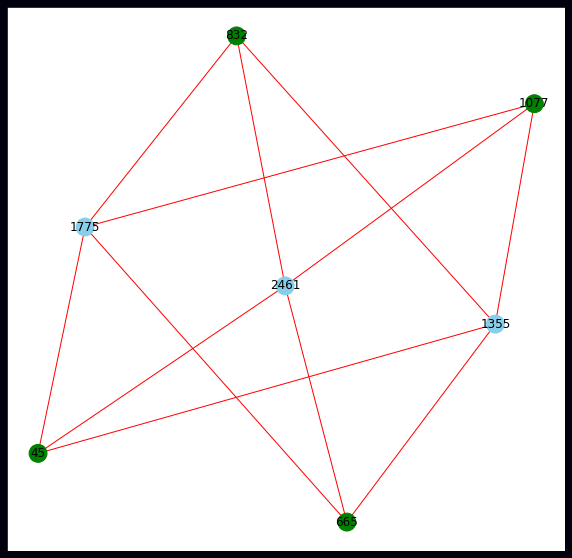

similar graph


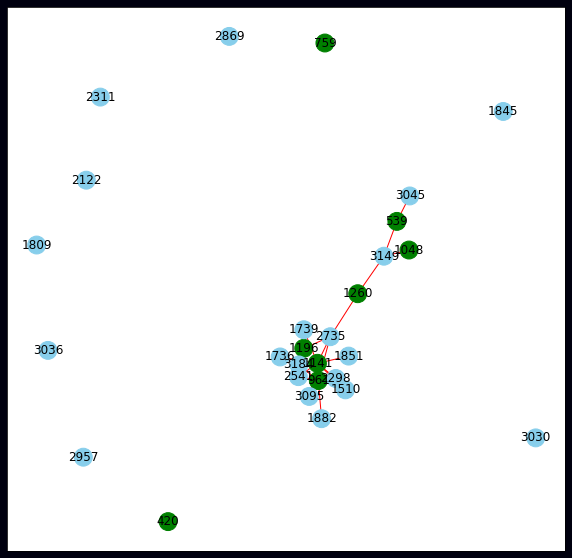

dissimilar graph


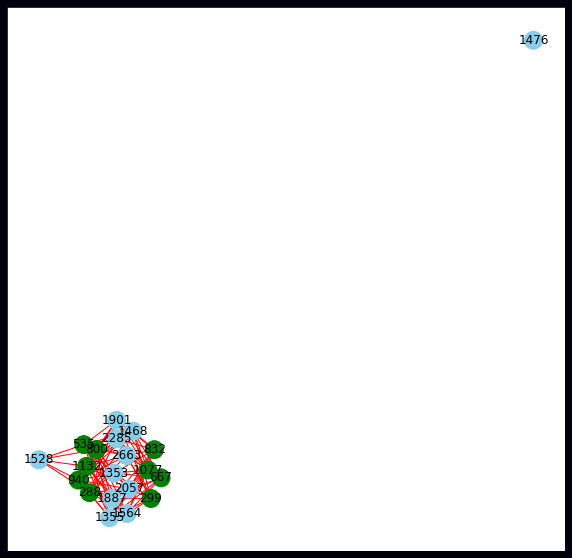

In [128]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import random
from util import EHRTokenizer

# graph = nx.Graph()
# graph.add_node(1)
# graph.add_nodes_from([2,3,4,5])
# for i in range(5):
#     for j in range(i):
#         if (abs(i-j) not in (1,4)):
#             graph.add_edge(i+1,j+1)

# nx.draw(graph,with_labels=True,edge_color='b',node_color='r')
# plt.show()

def draw_graph(node_ids,edges,diag_cnt):   
    graph = nx.Graph()
#     node_ids = [node[0] for node in node_ids]
    graph.add_nodes_from([node[0] for node in node_ids])
    color_list = ['green']*diag_cnt + ['skyblue']*(len(node_ids)-diag_cnt)
#     print([(i,j) for i,j in zip(edges[0,::2],edges[1,::2])])#(node_ids[i],node_ids[j])
    graph.add_edges_from([(node_ids[i][0],node_ids[j][0]) for i,j in zip(edges[0,::2],edges[1,::2])])#
#     assert len(node_ids) == len(graph.nodes)

    fig = plt.figure(figsize=(10,10))
    nx.draw_networkx(graph,with_labels=True,edge_color='red',node_color=color_list,node_size=320)
    fig.set_facecolor("#00000F")
    plt.show()

# seed = 182
# random.seed(seed)

#31814
flag = False
train_processed_file = 'no_p_a_dataset/train_remove_addm_undirect_onto_data.pt'
data_list = torch.load(train_processed_file)
node_max = 30
for i in range(1000):
    idx = random.randrange(0,len(data_list),2)
    sim_data, dissim_data = data_list[idx], data_list[idx+1]
    if len(sim_data.x_left.numpy())<node_max and len(sim_data.x_right.numpy())<node_max and len(dissim_data.x_left.numpy())<node_max and len(dissim_data.x_right.numpy())<node_max:
        flag = True
        print(idx,' get the nodes less than 40 examples')
        break
if flag:
    print('base graph')
    draw_graph(sim_data.x_left.numpy(), sim_data.edge_index_left.numpy(),sim_data.left_diag_cnt.item())
    # draw_graph(dissim_data.x_left.numpy(), dissim_data.edge_index_left.numpy())
    print('similar graph')
    draw_graph(sim_data.x_right.numpy(), sim_data.edge_index_right.numpy(),sim_data.right_diag_cnt.item())
    print('dissimilar graph')
    draw_graph(dissim_data.x_right.numpy(), dissim_data.edge_index_right.numpy(), dissim_data.right_diag_cnt.item())


# #获取主要疾病 在图中查看相关点
# admissions_file, labels_file = '../self_dataset/train_admissions.csv', '../self_dataset/train_label.csv'

# admissions_df, labels_df = pd.read_csv(admissions_file), pd.read_csv(labels_file,sep='\t',header=0,names=['left_hadm','right_hadm','label'])

# # print(admissions_df[admissions_df['disease']=='9100'])


# # print(labels_df[labels_df['left_hadm']==199077])
# # print(labels_df[labels_df['left_hadm']==185173])
# # print(labels_df[labels_df['left_hadm']==114553])

# # print(labels_df[labels_df['right_hadm']==199077])
# # print(labels_df[labels_df['right_hadm']==185173])
# # print(labels_df[labels_df['right_hadm']==114553])

# label_row = labels_df.iloc[29778]
# left_hadm,right_hadm = label_row['left_hadm'],label_row['right_hadm']

# vocab_file = '../self_dataset/vocab.pkl'
# tokenizer = EHRTokenizer(vocab_file,False)


# left_adm_dig = admissions_df[admissions_df['HADM_ID']==left_hadm]['disease']
# right_adm_dig = admissions_df[admissions_df['HADM_ID']==right_hadm]['disease']


# label_row = labels_df.iloc[29778+1]
# left_hadm,right_hadm = label_row['left_hadm'],label_row['right_hadm']


# left_adm_dig = admissions_df[admissions_df['HADM_ID']==left_hadm]['disease'].values[0]
# right_adm_dig = admissions_df[admissions_df['HADM_ID']==right_hadm]['disease'].values[0]

# adm_row =  admissions_df[admissions_df['HADM_ID']==right_hadm]

# print(tokenizer.vocab.word2idx['d_'+left_adm_dig])
# print(tokenizer.vocab.word2idx['d_'+right_adm_dig])

# print(left_adm_dig)
# print(right_adm_dig)
# left_adm = admiss
# all_hadm_ids = set()
# labels_df['left_hadm'].apply(lambda x:all_hadm_ids.add(x))
# labels_df['right_hadm'].apply(lambda x:all_hadm_ids.add(x))



# admissions_df = admissions_df[admissions_df['HADM_ID'].isin(all_hadm_ids)]

# admissions_df.to_csv(admissions_file,index=False)

# assert len(admissions_df)==len(all_hadm_ids)

In [129]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import pandas as pd
import random

def draw_graph(node_ids,edges):    
    graph = nx.Graph()
    graph.add_nodes_from([0,1,2])
#     print([(i,j) for i,j in zip(edges[0,::2],edges[1,::2])])#(node_ids[i],node_ids[j])
    graph.add_edges_from([(0,2),(1,2)])#

    fig = plt.figure()
    nx.draw_networkx(graph,with_labels=True,node_size=[300,300,300],node_color=['red','black','pink'],edge_color='blue')
    fig.set_facecolor("#00000F")
    plt.show()
    
# draw_graph(None,None)
vocab_file = '../self_dataset/vocab.pkl'
tokenizer = EHRTokenizer(vocab_file,False)

admissions_file, labels_file = '../self_dataset/train_admissions.csv', '../self_dataset/train_label.csv'

admissions_df, labels_df = pd.read_csv(admissions_file), pd.read_csv(labels_file,sep='\t',header=0,names=['left_hadm','right_hadm','label'])

print(tokenizer.vocab.idx2word[1148])
print(tokenizer.vocab.idx2word[832])

# print(admissions_df[admissions_df['disease']=='V3000'])
# print(admissions_df[admissions_df['disease']=='V053'])


# print(labels_df[labels_df['left_hadm']==199077])
# print(labels_df[labels_df['left_hadm']==185173])
# print(labels_df[labels_df['left_hadm']==114553])

# print(labels_df[labels_df['right_hadm']==199077])
# print(labels_df[labels_df['right_hadm']==185173])
# print(labels_df[labels_df['right_hadm']==114553])



d_632
d_53012


In [130]:
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import torch
import random
import numpy as np
from torch_geometric.data import InMemoryDataset,Data,DataLoader

class EHRPairData(Data):
    def __init__(self,x_left,edge_index_left,x_right,edge_index_right,left_diag_cnt,right_diag_cnt,y):
        super(EHRPairData,self).__init__()
        self.x_left = x_left
        self.edge_index_left = edge_index_left
        self.x_right = x_right
        self.edge_index_right = edge_index_right
        self.left_diag_cnt = left_diag_cnt
        self.right_diag_cnt = right_diag_cnt
        self.y = y
        
    def __inc__(self,key,value):
        if key=='edge_index_left':
            return  self.x_left.size(0)
        if key=='edge_index_right':
            return self.x_right.size(0)
        else:
            return super(EHRPairData,self).__inc__(key,value)

def draw_graph(edges_len,max_num):
    edges_len = np.array(edges_len)
    print(np.mean(edges_len))
    """plt.hist(edges_len,bins=8,range=(0,max_num))
    plt.show()"""

seed = 102
random.seed(seed)
# processed_files = ['no_p_a_dataset/train_remove_addm_undirect_onto_data.pt','no_p_a_dataset/test_remove_addm_undirect_onto_data.pt','no_p_a_dataset/valid_remove_addm_undirect_onto_data.pt']
processed_files = ['all_dataset/train_pa_include_remove_addm_undirect_onto_data.pt','all_dataset/valid_pa_include_remove_addm_undirect_onto_data.pt']
processed_files = ['all_dataset/test_pa_include_remove_addm_undirect_onto_data.pt']
for train_processed_file in processed_files:
    _,data_list = torch.load(train_processed_file)

    sim_distri_hist, dis_distri_hist, edges_len, nodes_cnt = [], [] ,[], []
    sim_nodes_gap_hist, dis_nodes_gap_hist = [],[]
    new_data_list = []
    for idx,data in enumerate(data_list):
        nodes_cnt.append(len([t_id[0] for t_id in data.x.numpy()]))
        edges_len.append(len(data.edge_index.numpy()[0] )//2)
        """left_graph_ids = [t_id[0] for t_id in data.x_left.numpy()]
        right_graph_ids = [t_id[0] for t_id in data.x_right.numpy()]

        left_link_ids = data.edge_index_left.numpy()[0]
        right_link_ids = data.edge_index_right.numpy()[0] 

        if idx%20==0:
            nodes_cnt.append(len(left_graph_ids))
#         nodes_cnt.append(len(right_graph_ids))
        
        if idx%20==0:
            edges_len.append(len(left_link_ids)//2)"""
#         edges_len.append(len(right_link_ids)//2)
        
#         common_nodes = len(set(left_graph_ids)&set(right_graph_ids))
#         common_sim_ratio = common_nodes#/(150*150)#(len(left_graph_ids)*len(right_graph_ids))
#         if idx%2==0:sim_distri_hist.append(common_sim_ratio)
#         else:dis_distri_hist.append(common_sim_ratio)
            
#         if idx%2==0:sim_nodes_gap_hist.append(abs(len(left_graph_ids)-len(right_graph_ids)))
#         else:dis_nodes_gap_hist.append(abs(len(left_graph_ids)-len(right_graph_ids)))

#         if len(left_graph_ids)>150 or len(right_graph_ids)>150:continue
#         if len(left_link_ids)//2>100 or len(right_link_ids)//2>100:continue

#         new_data_list.append(data)
    

#         left_graph_ids = [left_graph_ids[idx] for idx in left_link_ids]
#         right_graph_ids = [right_graph_ids[idx] for idx in right_link_ids]

        """left_unlink_ids,right_unlink_ids = [],[]
        for i in range(len(left_graph_ids)):
            if i not in left_link_ids:left_unlink_ids.append(i)
        for i in range(len(right_graph_ids)):
            if i not in right_link_ids:right_unlink_ids.append(i)
        left_link_ids,right_link_ids = left_unlink_ids,right_unlink_ids


        left_graph_ids = [left_graph_ids[idx] for idx in left_link_ids]
        right_graph_ids = [right_graph_ids[idx] for idx in right_link_ids]

        if len(left_graph_ids)==0 or len(right_graph_ids)==0:continue"""
#         print(data.y)
        
    
    """plt.hist([sim_nodes_gap_hist,dis_nodes_gap_hist],bins=8,range=(0,100),label=['similar','dissimilar'])
    plt.legend(loc='upper right')
    plt.show()
    plt.hist([sim_distri_hist,dis_distri_hist],bins=8,range=(0,50),label=['similar','dissimilar'])#range=(0,0.002),
    plt.legend(loc='upper right')
    plt.show()
    print('raw data cnt is ',len(data_list),', current data cnt is ',len(new_data_list)) """ 
    draw_graph(edges_len,100)
    draw_graph(nodes_cnt,150)

"""draw_graph(edges_len,100)
draw_graph(nodes_cnt,150)"""
# assert len(sim_distri_hist)==len(dis_distri_hist)
# plt.hist(sim_distri_hist,bins=8,range=(0,0.1))


ValueError: too many values to unpack (expected 2)

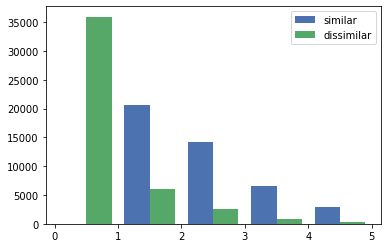

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
import pandas as pd

raw_files = ['../self_dataset/train_label.csv','../self_dataset/test_label.csv','../self_dataset/valid_label.csv']
raw_dfs = [pd.read_csv('../self_dataset/train_admissions.csv'),pd.read_csv('../self_dataset/test_admissions.csv'),pd.read_csv('../self_dataset/valid_admissions.csv')]

def cal_common_nodes(label_df,details_df):
    common_nodes_cnt = []
    for idx,row in label_df.iterrows():
        left_atc_codes = set(details_df[details_df['HADM_ID']==row['left_hadmid']]['ATC'].values[0].split(','))
        right_atc_codes = set(details_df[details_df['HADM_ID']==row['right_hadmid']]['ATC'].values[0].split(','))
        
        left_proce_codes = set(details_df[details_df['HADM_ID']==row['left_hadmid']]['ICD9_PROCE'].values[0].split(','))
        right_proce_codes = set(details_df[details_df['HADM_ID']==row['right_hadmid']]['ICD9_PROCE'].values[0].split(','))
        
        left_disease_codes = set(details_df[details_df['HADM_ID']==row['left_hadmid']]['ICD9_DIAG'].values[0].split(','))
        right_disease_codes = set(details_df[details_df['HADM_ID']==row['right_hadmid']]['ICD9_DIAG'].values[0].split(','))
        
        all_common_cnt = len(list(left_disease_codes & right_disease_codes))
  
#         all_common_cnt = len(list(left_atc_codes & right_atc_codes)) + len(list(left_proce_codes & right_proce_codes)) + len(list(left_disease_codes & right_disease_codes))
        
        
        common_nodes_cnt.append(all_common_cnt)
    return common_nodes_cnt



for file,raw_df in zip(raw_files,raw_dfs):
    file_df = pd.read_csv(file,sep='\t',header=0,names=['left_hadmid','right_hadmid','label'])
    similar_df = file_df[file_df['label']==1]
    dis_sim_df = file_df[file_df['label']==0]
    sim_nodes_cnt = cal_common_nodes(similar_df,raw_df)
    dis_nodes_cnt = cal_common_nodes(dis_sim_df,raw_df)
    
    plt.hist([sim_nodes_cnt,dis_nodes_cnt],bins=5,range=(0,5),label=['similar','dissimilar'])
    plt.legend(loc='upper right')
    plt.show()

In [131]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


decision_node = dict(boxstyle="sawtooth",fc="0.8")
leaf_node = dict(boxstyle="round4",fc="0.8")
arrow_args = dict(arrowstyle="<-")
#获取树的叶子结点个数（确定图的宽度）
def get_leaf_num(tree):
    leaf_num = 0
    first_key = list(tree.keys())[0]
    next_dict = tree[first_key]
    print(next_dict)
    for key in next_dict.keys():
        if type(next_dict[key]).__name__=="dict":
            leaf_num +=get_leaf_num(next_dict[key])
        else:
            leaf_num +=1
    return leaf_num
#获取数的深度（确定图的高度）
def get_tree_depth(tree):
    depth = 0
    first_key = list(tree.keys())[0]
    next_dict = tree[first_key]
    for key in next_dict.keys():
        if type(next_dict[key]).__name__ == "dict":
            thisdepth = 1+ get_tree_depth(next_dict[key])
        else:
            thisdepth = 1
        if thisdepth>depth: depth = thisdepth
    return depth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

#在父子节点间填充文本信息
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = get_leaf_num(myTree)
    depth = get_tree_depth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decision_node)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[
                    key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leaf_node)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD



def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(get_leaf_num(inTree))
    plotTree.totalD = float(get_tree_depth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()
    
from treelib import Node, Tree
    
def load_rel():
    pmi_threshold = 1
    rel_dir = '../self_kg/'
    diag_proce_df = pd.read_csv(rel_dir+'diag_proce_rel.csv',sep='\t')
    diag_proce_df = diag_proce_df[diag_proce_df['pmi']>pmi_threshold]
    diag_pres_df = pd.read_csv(rel_dir+'diag_pres_rel.csv',sep='\t',dtype={'tail ent':str})
    diag_pres_df = diag_pres_df[diag_pres_df['pmi']>pmi_threshold]
    proce_pres_df = pd.read_csv(rel_dir+'proce_pres_rel.csv',sep='\t',dtype={'tail ent':str})
    proce_pres_df = proce_pres_df[proce_pres_df['pmi']>pmi_threshold]

    ndc2rxnorm_file = 'ndc_atc/ndc2rxnorm_mapping.txt'
    with open(ndc2rxnorm_file,'r') as f:
        ndc2rxnorm = eval(f.read())

    diag_proce_pairs = []
    diag_proce_df.apply(lambda row:diag_proce_pairs.append(str(row['head ent'])+'-'+str(row['tail ent'])),axis=1)

    diag_pres_pairs = []
    diag_pres_df.apply(lambda row:diag_pres_pairs.append(str(row['head ent'])+'-'+ndc2rxnorm[row['tail ent']]),axis=1)

    proce_pres_pairs = []
    proce_pres_df.apply(lambda row:proce_pres_pairs.append(str(row['head ent'])+'-'+ndc2rxnorm[row['tail ent']]),axis=1)
    
    return diag_proce_pairs, diag_pres_pairs, proce_pres_pairs
                     
    
diag_proce_pairs, diag_pres_pairs, proce_pres_pairs = load_rel()


import random

def draw_trees(left_disease_codes,left_proce_codes,left_atc_codes):
    left_tree = Tree()
  
    left_tree.create_node('graph','left_graph')
    leftTrees = {'left_graph':{}}
    for left_diag in left_disease_codes:
        for left_proce in left_proce_codes:
            if left_diag+'-'+left_proce in diag_proce_pairs:                  
                if left_diag not in leftTrees['left_graph']:
                    leftTrees['left_graph'][left_diag]={}
                    if not left_tree.contains(left_diag):
                        left_tree.create_node(left_diag,left_diag,parent='left_graph')
                leftTrees['left_graph'][left_diag][len(leftTrees['left_graph'][left_diag])] = left_proce
                if not left_tree.contains(left_proce):
                    left_tree.create_node(left_proce,left_proce,parent=left_diag)
                else:
                    left_tree.create_node(left_proce,left_proce+str(random.random()),parent=left_diag)

    for left_diag in left_disease_codes:
        for left_pres in left_atc_codes:
            if left_diag+'-'+left_pres in diag_pres_pairs:
                if left_diag not in leftTrees['left_graph']:
                    leftTrees['left_graph'][left_diag]={}
                    if not left_tree.contains(left_diag):
                        left_tree.create_node(left_diag,left_diag,parent='left_graph')
                leftTrees['left_graph'][left_diag][len(leftTrees['left_graph'][left_diag])] = left_pres
                if not left_tree.contains(left_pres):
                    left_tree.create_node(left_pres,left_pres,parent=left_diag)
                else:
                    left_tree.create_node(left_pres,left_pres+str(random.random()),parent=left_diag)
    left_tree.show()
        
def cal_common_nodes(label_df,details_df):
    common_nodes_cnt = []
    for idx,row in label_df.iterrows():
        left_atc_codes = set(details_df[details_df['HADM_ID']==row['left_hadmid']]['ATC'].values[0].split(','))
        right_atc_codes = set(details_df[details_df['HADM_ID']==row['right_hadmid']]['ATC'].values[0].split(','))
        
        left_proce_codes = set(details_df[details_df['HADM_ID']==row['left_hadmid']]['ICD9_PROCE'].values[0].split(','))
        right_proce_codes = set(details_df[details_df['HADM_ID']==row['right_hadmid']]['ICD9_PROCE'].values[0].split(','))
        
        left_disease_codes = set(details_df[details_df['HADM_ID']==row['left_hadmid']]['ICD9_DIAG'].values[0].split(','))
        right_disease_codes = set(details_df[details_df['HADM_ID']==row['right_hadmid']]['ICD9_DIAG'].values[0].split(','))
        
        draw_trees(left_disease_codes,left_proce_codes,left_atc_codes)
        draw_trees(right_disease_codes,right_proce_codes,right_atc_codes)
        
        break



raw_files = ['../self_dataset/train_label.csv','../self_dataset/test_label.csv','../self_dataset/valid_label.csv']
raw_dfs = [pd.read_csv('../self_dataset/train_admissions.csv'),pd.read_csv('../self_dataset/test_admissions.csv'),pd.read_csv('../self_dataset/valid_admissions.csv')]

for file,raw_df in zip(raw_files,raw_dfs):
    file_df = pd.read_csv(file,sep='\t',header=0,names=['left_hadmid','right_hadmid','label'])
    similar_df = file_df[file_df['label']==1]
    dis_sim_df = file_df[file_df['label']==0]
    cal_common_nodes(similar_df,raw_df)
    cal_common_nodes(dis_sim_df,raw_df)
    break
     

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import random
test_admission_df = pd.read_csv('../self_dataset/test_admissions.csv')
print(test_admission_df.columns)
# print(test_admission_df.groupby('disease').size().reset_index(name='count').sort_values(['count'],ascending=False))

Index(['SUBJECT_ID', 'HADM_ID', 'ICD9_DIAG', 'ICD9_PROCE', 'NDC', 'disease',
       'ATC'],
      dtype='object')


In [ ]:
import torch
data_save_file = 'no_p_a_dataset/valid_remove_addm_undirect_onto_data.pt'
data_list = torch.load(data_save_file)

for data in data_list:
    data['labels_1'] = [val for val in data.x_left.squeeze(dim=-1).numpy()]
    data['labels_2'] = [val for val in data.x_right.squeeze(dim=-1).numpy()]
    graph_1 = data.edge_index_left.numpy()
    data['graph_1'] = [[edge_1,edge_2] for edge_1,edge_2 in zip(graph_1[0],graph_1[1])]
    graph_2 = data.edge_index_right.numpy()
    data['graph_2'] = [[edge_1,edge_2] for edge_1,edge_2 in zip(graph_2[0],graph_2[1])]
    data['target'] = data.y
    break
#     data['graph_1'] = 
#     data['graph_2'] = 
#     data[]
#     data['target']

In [ ]:
import torch
import json
import os
from torch_geometric.data import InMemoryDataset,Data,DataLoader
class EHRPairData(Data):
    def __init__(self,x_left,edge_index_left,x_right,edge_index_right,left_diag_cnt,right_diag_cnt,y):
        super(EHRPairData,self).__init__()
        self.x_left = x_left
        self.edge_index_left = edge_index_left
        self.x_right = x_right
        self.edge_index_right = edge_index_right
        self.left_diag_cnt = left_diag_cnt
        self.right_diag_cnt = right_diag_cnt
        self.y = y
        
    def __inc__(self,key,value):
        if key=='edge_index_left':
            return  self.x_left.size(0)
        if key=='edge_index_right':
            return self.x_right.size(0)
        else:
            return super(EHRPairData,self).__inc__(key,value)

# data_path = 'no_p_a_dataset/valid_remove_addm_undirect_onto_data.pt'
# save_path = 'baselines/graph2vec-master/mimic_valid_dataset'
# data_path = 'no_p_a_dataset/query_remove_addm_undirect_onto_data.pt'
#save_path = 'baselines/graph2vec-master/mimic_query_dataset'
data_path = 'no_p_a_dataset/test_query_remove_addm_undirect_onto_data.pt'
save_path = 'baselines/graph2vec-master/mimic_test_query_dataset/'

graphs = []

def get_json_str(x_left, edge_index_left):
    graph_1 = edge_index_left.numpy().tolist()
    edges = [[edge_1,edge_2] for edge_1,edge_2 in zip(graph_1[0],graph_1[1])]
    features = {str(idx):str(val) for idx,val in enumerate(x_left.squeeze(dim=-1).numpy())}
    label = str(x_left.squeeze(dim=-1).numpy()[0])
            
    return {'edges':edges,'features':features,'label':label}

def construct_graphs(input_path):
    graph_start = 0
    data_list,right_ids = torch.load(input_path)
    label_writer = open(os.path.join(save_path,'label.txt'),'w')
    label_writer.write('left_hadm\tright_hadm\tlabel\n')
    for data_idx in range(len(data_list)):
        if data_idx%2==0:
            json_str = get_json_str(data_list[data_idx].x_left, data_list[data_idx].edge_index_left)
            json.dump(json_str,open(os.path.join(save_path,str(graph_start)+'.json'),'w'))#
            left_graph = graph_start
            graph_start += 1
        json_str = get_json_str(data_list[data_idx].x_right, data_list[data_idx].edge_index_right)
        json.dump(json_str,open(os.path.join(save_path,str(graph_start)+'.json'),'w'))#
        right_graph = graph_start
        graph_start += 1
        label = data_list[data_idx].y.item()
        label_writer.write(str(left_graph)+'\t'+str(right_graph)+'\t'+str(label)+'\n')    
    print('graphs construct done...')

def construct_query_graphs(input_path):
    print('begin to load the file...')
    aff_mat, cohorts, data_list = torch.load(input_path)#,right_ids
    print(len(data_list),len(cohorts))
    print('loading from dataset done...')
    res, cnts,cnt = [], [],0
    for i in range(len(cohorts)):  
        cnts.append(cnt)
        for j in range(i+1,len(cohorts)):
            cnt +=  1
       
    for i in range(len(cnts)-1):
        cnt = cnts[i]
        json_str = get_json_str(data_list[cnt].x_left, data_list[cnt].edge_index_left)
        json_str['label'] = cohorts[i]
        json.dump(json_str,open(os.path.join(save_path,str(cnt)+'.json'),'w'))
    json_str = get_json_str(data_list[cnt].x_right, data_list[cnt].edge_index_right)
    json_str['label'] = cohorts[-1]
    json.dump(json_str,open(os.path.join(save_path,str(cnt+1)+'.json'),'w'))        
    print('graphs construct done...')

# aff_mat, cohorts, data_list = torch.load(data_path)
graphs = construct_query_graphs(data_path)
# import glob
# graphs = glob.glob(save_path + "*.json")
# print(len(graphs))
# print(set([json.load(open(f,'r'))['label'] for f in graphs]))
# # res = json.load(open(os.path.join(save_path,str(0)+'.json'),'r'))
# print(res)

begin to load the file...
2210253 2103
loading from dataset done...
graphs construct done...


In [ ]:
import pickle
res = pickle.load(open('../self_dataset/vocab.pkl','rb'))
def write_to_txt(code_list,code_file):
    for code in code_list:
        code_file.write(code+'\n')
write_to_txt(res['diag_codes'],open('diag_code.txt','w'))
write_to_txt(res['proce_codes'],open('proce_code.txt','w'))

ndc2rxnorm_file = 'ndc_atc/ndc2rxnorm_mapping.txt'
with open(ndc2rxnorm_file,'r') as f:
    ndc2rxnorm = eval(f.read())
atc2ndc_dic = {}
for key,val in ndc2rxnorm.items():
    atc2ndc_dic[val] = key
write_to_txt([atc2ndc_dic[code] for code in res['atc_codes']],open('pres_code.txt','w'))
# codes_dict = pickle.load()#{'diag_codes':all_diag_codes,'proce_codes':all_proce_codes,'atc_codes':all_atc_codes}
# print(codes_dict)

In [ ]:
ndc2rxnorm_file = 'ndc_atc/ndc2rxnorm_mapping.txt'
with open(ndc2rxnorm_file,'r') as f:
    ndc2rxnorm = eval(f.read())
# print(ndc2rxnorm)

In [ ]:
# train our image dataset
from PIL import Image
from torchvision import transforms,models
import torch
import os
import pickle

process = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

model = models.resnet50(pretrained=True)
model = model.cuda()
model.eval()

target_module = [m for m in  model.modules()][-2]

class LayerPool:
    
    def __init__(self,model):
        self.hook = model.register_forward_hook(self.hook_fn)
        
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
        
    def remove(self):
        self.hook.remove()

final_out = LayerPool(target_module)
        
def process_image(image_path,code_raw_file):
    code_ls = [line.strip() for line in open(code_raw_file,'r').readlines()]
    valid_image_tensors = []
    valid_codes = []
    
    code_dict = {}
    for code in code_ls:
        if code_raw_file.startswith('pres'):
            image_file = os.path.join(image_path,code.lstrip('0')+'.jpg')
        else:
            image_file = os.path.join(image_path,code+'.jpg')
        if not os.path.exists(image_file):
            continue
        try:
            image_file = Image.open(image_file).convert('RGB')
            
            input_batch = process(image_file).unsqueeze(0).cuda()
            
            with torch.no_grad():
                output = model(input_batch)
#                 final_out.remove()

                embed_out = final_out.features.squeeze(-1).squeeze(-1).squeeze(0)
            
            valid_image_tensors.append(embed_out)
            valid_codes.append(code)
            
            code_dict[code] = embed_out
        except:
            print('convert RGB error')
    print(' done one ')        
    return code_dict
        
def write_image_emb(save_file):
    diag_dict = process_image('/home/lf/桌面/Img/submit/DIAImg/','diag_code.txt')
    pres_dict = process_image('/home/lf/桌面/Img/submit/DrugImg/','pres_code.txt')
    proce_dict = process_image('/home/lf/桌面/Img/submit/ProImg/','proce_code.txt')
    
    writer = open(save_file,'wb')
    
    pickle.dump({'diag_img':diag_dict,'pres_img':pres_dict,'proce_img':proce_dict},writer)

write_image_emb('../self_dataset/vocab_image_emb.pkl')


 done one 
 done one 
 done one 


In [ ]:
"""import pandas as pd
import random
test_admission_df = pd.read_csv('../self_dataset/test_admissions.csv')
valid_ad_ids = test_admission_df.groupby('disease').size().reset_index(name='count').sort_values(['count'],ascending=False)['disease'].values[:10]
filtered_ids = test_admission_df[test_admission_df['disease'].isin(valid_ad_ids)]
filtered_ids.to_csv('../self_dataset/cluster_admissions.csv',index=False)"""

import pandas as pd
import numpy as np
from pylmnn import LargeMarginNearestNeighbor
from sklearn.cluster import KMeans

train_file = '../self_dataset/train_admissions.csv'
test_file = '../self_dataset/test_admissions.csv'

def construct_x_y(input_file):
    test_admission_df = pd.read_csv(input_file)
    
    atc_codes, diag_codes, proce_codes = [], [], []
    test_admission_df['ATC'].apply(lambda x:atc_codes.extend(x.split(',')))
    test_admission_df['ICD9_DIAG'].apply(lambda x:diag_codes.extend(x.split(',')))
    test_admission_df['ICD9_PROCE'].apply(lambda x:proce_codes.extend(x.split(',')))
    atc_codes = list(set(atc_codes))
    diag_codes = list(set(diag_codes))
    proce_codes = list(set(proce_codes))
    medical_code_num = len(diag_codes)+len(proce_codes)+len(atc_codes)

    diseases = list(set(test_admission_df['disease'].values))

    admissions_reps, y = np.zeros((len(test_admission_df),medical_code_num)), []
    for idx,row in test_admission_df.iterrows():
        code_idxs = np.array([diag_codes.index(diag_code) for diag_code in row['ICD9_DIAG'].split(',')])
        code_idxs = np.concatenate((code_idxs, len(diag_codes)+np.array([proce_codes.index(proce_code) for proce_code in row['ICD9_PROCE'].split(',')])))
        code_idxs = np.concatenate((code_idxs, len(diag_codes)+len(proce_codes)+np.array([atc_codes.index(atc_code) for atc_code in row['ATC'].split(',')])))

        admissions_reps[idx,code_idxs]=1

        y.append(diseases.index(row['disease']))
        
    return admissions_reps, np.array(y), len(diseases)

train_x,train_y,_ = construct_x_y(train_file)
test_x, test_y, cohorts_num = construct_x_y(test_file)
print('data construct done')


#LMNN with KMeans
lmnn = LargeMarginNearestNeighbor(n_neighbors=3, random_state=42)
lmnn.fit(train_x,train_y)
print('training done')

test_predict = KMeans(n_clusters=cohorts_num).fit_predict(lmnn.transform(test_x))
print(test_predict)

data construct done
training done


ValueError: shapes (5983,3237) and (3249,3249) not aligned: 3237 (dim 1) != 3249 (dim 0)

In [ ]:
#Eud
test_predict = KMeans(n_clusters=cohorts_num).fit_predict(test_x)
print(test_predict)
from metric_learn  import ITML_Supervised
itml = ITML_Supervised()
itml.fit(train_x,train_y)
test_predict = KMeans(n_clusters=cohorts_num).fit_predict(itml.transform(test_x))
print(test_predict)

In [ ]:
import pandas as pd
import numpy as np
from pylmnn import LargeMarginNearestNeighbor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# 2021/10/26 找六种病的代码的第一部分
import numpy as np

empty_g_16 = "../mimic-iv/empty_g_a.txt"

empty_g_test = []

ff = open(empty_g_16, "r")

data = ff.readlines()

# print(data)

for item in data:
    item = item.replace("\n", "")
    empty_g_test.append(item)



In [3]:
import pandas as pd
import numpy as np
from pylmnn import LargeMarginNearestNeighbor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

# 三个mimic-iv原始文件的文件名
train_file = '../self_dataset/train_admissions.csv'
test_file = '../self_dataset/test_admissions.csv'
valid_file = '../self_dataset/valid_admissions.csv'



# 读取三个文件
train_admission_df = pd.read_csv(train_file)
test_admission_df = pd.read_csv(test_file)
valid_admission_df = pd.read_csv(valid_file)
disease_cohorts = list(train_admission_df['disease'].value_counts().index.values[1:9])

# ['V3000', 'V502', 'V3001', '4019', '2724', 'V290']
# {'accu': 0.6403743315508021, 'precision': 0.6396027370449158, 'recall': 0.6433129611288587, 'f1': 0.6410238766679833}
# the best metric(purity) for test model purity:  0.5940285204991087  nmi: 0.5588945646436015  me_ri:  0.78907363212784
print(disease_cohorts)

# 学姐代码中找出的病
# disease_cohorts = ['41401', 'V3001', 'V3000','4019','4241','0389']

# 自己实验的一种组合
# disease_cohorts = ['V3000', 'V3001', '2724', '4019']  
# 0.8964  0.8427  0.95542 {'accu': 0.8957345971563981, 'precision': 0.8248150215961519, 'recall': 0.8213674740818322, 'f1': 0.8223302922612429}

# disease_cohorts = ['V3000', 'V3001', '2724', '25000', ]  
# purity:  0.9197530864197531  nmi: 0.8764422440628078  me_ri:  0.9751108251108251 {'accu': 0.9552469135802469, 'precision': 0.8909906274407706, 'recall': 0.8895234598273412, 'f1': 0.8902028172619717}

# 自己实验的一种组合(目前聚类效果最好的四种)
# disease_cohorts = ['V3000', 'V3001', '4019', '30000'] 

# 10/28 
# disease_cohorts = ['V3000', 'V3001', '4019', '30000', '42789', 'E8499'] 

# 10/28  效果不错
# disease_cohorts = ['V3000', 'V3001', '4019', '30000']

# 10/28 
# disease_cohorts = ['V3000', 'V3001', '40390', 'E8499', '42789'] 
# 效果很好

# this
# disease_cohorts = ['V3000', 'V3001', '4019', '30000'] 
# disease_cohorts = ['41401', 'V3001', 'V3000','4019','4241','0389']

# 1202
disease_cohorts = ['V3000', 'V3001', '4019', 'V290', '53081', '41401']
# disease_cohorts = ['V3000']



# 去掉空图
test_admission_df = test_admission_df[~(test_admission_df['HADM_ID'].isin(empty_g_test))]
train_admission_df = train_admission_df[~(train_admission_df['HADM_ID'].isin(empty_g_test))]
valid_admission_df = valid_admission_df[~(valid_admission_df['HADM_ID'].isin(empty_g_test))]


# 从原始的数据文件中取出所需要数据
train_admission_df = train_admission_df[train_admission_df['disease'].isin(disease_cohorts)]
print(len(train_admission_df))
test_admission_df = test_admission_df[test_admission_df['disease'].isin(disease_cohorts)]
print(len(test_admission_df))
valid_admission_df = valid_admission_df[valid_admission_df['disease'].isin(disease_cohorts)]
print(len(valid_admission_df))



# 保存数据
train_admission_df.to_csv('../large_cluster_dataset/train_admissions.csv',index=False)
test_admission_df.to_csv('../large_cluster_dataset/test_admissions.csv',index=False)
valid_admission_df.to_csv('../large_cluster_dataset/valid_admissions.csv',index=False)

['V3000', 'V502', 'V3001', '4019', '2724', 'V290', '53081', '41401']
5142
1695
1657


In [4]:
import pandas as pd

test_file = '../large_cluster_dataset/test_admissions.csv'
test_admission_df = pd.read_csv(test_file)
decrease = 1
# decrease = 180
drops_id = []

for i in range(0, len(test_admission_df['disease'])):
    if test_admission_df['disease'][i] == 'V3000' :
        drops_id.append(test_admission_df['HADM_ID'][i])
        decrease = decrease - 1
        if decrease == 0:
            break

# decrease = 180
decrease = 1
for i in range(0, len(test_admission_df['disease'])):
    if test_admission_df['disease'][i] == 'V3001' :
        drops_id.append(test_admission_df['HADM_ID'][i])
        decrease = decrease - 1
        if decrease == 0:
            break

test_admission_df = test_admission_df[~test_admission_df['HADM_ID'].isin(drops_id)]

test_admission_df.to_csv('../large_cluster_dataset/test_admissions.csv',index=False)


In [21]:
by_disease = test_admission_df.groupby('disease')['HADM_ID'].unique().reset_index()

tt = zip(by_disease['disease'],by_disease['HADM_ID'])

# for disease,hadm_ids in  tt:
#      print(disease, len(hadm_ids))
     # print(hadm_ids)
     # print(len(hadm_ids))


# 查看疾病之间的重复率
repeat_dis = test_admission_df['ICD9_DIAG']
# print(repeat_dis)
for diss, hadm_ids in tt:
     cc = 0
     for stra in test_admission_df['ICD9_DIAG']:
          if diss in stra:
               cc = cc + 1
     labels = len(hadm_ids)
     print(diss, "total num: ", cc, " label num: ", labels)
     
     print("disease repeat rate:", (cc-labels*1.0)/cc)

tt = zip(by_disease['disease'],by_disease['HADM_ID'])
print("\n\n")
dissa = "41401"
for diss, hadm_ids in tt:
     if diss == dissa:continue
     cc = 0
     aa = 0
     for stra in test_admission_df['ICD9_DIAG']:
          stra_split = stra.split(",")
          if diss == stra_split[0]:
               # print(stra_split)
               for k in range(1, len(stra_split)):
                    if dissa == stra_split[k]:
                         cc = cc + 1
                         break
     labels = len(hadm_ids)
     print(dissa," ", diss," repeat num: ", cc)


    # print(all_disease_counts[diss])

4019 total num:  399  label num:  278
disease repeat rate: 0.3032581453634085
41401 total num:  238  label num:  139
disease repeat rate: 0.41596638655462187
53081 total num:  172  label num:  104
disease repeat rate: 0.3953488372093023
V290 total num:  286  label num:  163
disease repeat rate: 0.43006993006993005
V3000 total num:  774  label num:  677
disease repeat rate: 0.12532299741602068
V3001 total num:  378  label num:  332
disease repeat rate: 0.12169312169312169



41401   4019  repeat num:  76
41401   53081  repeat num:  23
41401   V290  repeat num:  0
41401   V3000  repeat num:  0
41401   V3001  repeat num:  0


In [6]:
by_disease = valid_admission_df.groupby('disease')['HADM_ID'].unique().reset_index()

tt = zip(by_disease['disease'],by_disease['HADM_ID'])

# for disease,hadm_ids in  tt:
#      print(disease, len(hadm_ids))
     # print(hadm_ids)
     # print(len(hadm_ids))


# 查看疾病之间的重复率
repeat_dis = valid_admission_df['ICD9_DIAG']
# print(repeat_dis)
for diss, hadm_ids in tt:
     cc = 0
     for stra in valid_admission_df['ICD9_DIAG']:
          if diss in stra:
               cc = cc + 1
     labels = len(hadm_ids)
     print(diss, "total num: ", cc, " label num: ", labels)
     
     print("disease repeat rate:", (cc-labels*1.0)/cc)


    # print(all_disease_counts[diss])

4019 total num:  405  label num:  279
disease repeat rate: 0.3111111111111111
41401 total num:  215  label num:  125
disease repeat rate: 0.4186046511627907
53081 total num:  162  label num:  98
disease repeat rate: 0.3950617283950617
V290 total num:  282  label num:  162
disease repeat rate: 0.425531914893617
V3000 total num:  766  label num:  682
disease repeat rate: 0.10966057441253264
V3001 total num:  364  label num:  311
disease repeat rate: 0.14560439560439561


In [7]:
by_disease = train_admission_df.groupby('disease')['HADM_ID'].unique().reset_index()

tt = zip(by_disease['disease'],by_disease['HADM_ID'])

# for disease,hadm_ids in  tt:
#      print(disease, len(hadm_ids))
     # print(hadm_ids)
     # print(len(hadm_ids))


# 查看疾病之间的重复率
repeat_dis = train_admission_df['ICD9_DIAG']
# print(repeat_dis)
for diss, hadm_ids in tt:
     cc = 0
     for stra in train_admission_df['ICD9_DIAG']:
          if diss in stra:
               cc = cc + 1
     labels = len(hadm_ids)
     print(diss, "total num: ", cc, " label num: ", labels)
     
     print("disease repeat rate:", (cc-labels*1.0)/cc)




    # print(all_disease_counts[diss])

4019 total num:  1263  label num:  861
disease repeat rate: 0.3182897862232779
41401 total num:  696  label num:  382
disease repeat rate: 0.4511494252873563
53081 total num:  605  label num:  379
disease repeat rate: 0.37355371900826445
V290 total num:  870  label num:  506
disease repeat rate: 0.41839080459770117
V3000 total num:  2316  label num:  2058
disease repeat rate: 0.11139896373056994
V3001 total num:  1127  label num:  956
disease repeat rate: 0.15173025732031944


In [8]:
# 最后一步 在large_cluster_dataset文件夹中生成train_admission.csv valid_admission.csv test_admission.csv 
#          train_label.csv valid_label.csv test_label.csv
# 之后：
# 1、删除掉data2/lc/mimic全/mimic_tester/all_dataset文件夹中所有的.pt文件
# 2、点击terminal->new_terminal
# 3、cd 至 mimic_tester文件夹中  cd mimic_tester
# 4、激活pytorch环境     conda activate pytorch
# 5、执行学姐给的命令     不用do query
# 6、如果跑代码过程中出现test admission构建了empty graph， 则需要从step1重新开始执行

import random
def construct_labels(test_admission_df,label_file):
    
    similar_pairs,dis_similar_pairs,disease_hadm_ids = [],[],{}
    by_disease_df = test_admission_df.groupby('disease')['HADM_ID'].unique().reset_index()
    all_hadm_ids = test_admission_df['HADM_ID'].tolist()
    for disease,hadm_ids in  zip(by_disease_df['disease'],by_disease_df['HADM_ID']):
        if len(hadm_ids)==1:continue
        hadm_ids = hadm_ids.tolist()
        # print(hadm_ids)
        for admission_id in hadm_ids:
            similar_hadm_ids = random.sample(hadm_ids, 20) #5 to 2
            [similar_pairs.append((admission_id,similar_id)) for similar_id in similar_hadm_ids]
            other_hadm_ids = random.sample(list(set(all_hadm_ids)-set(hadm_ids)), 20)
            for o_admission_id in other_hadm_ids:
                dis_similar_pairs.append((admission_id,o_admission_id))
                
    print('construct labels with similar and dissimilar counts: ',len(similar_pairs),len(dis_similar_pairs))            
    with open(label_file,'w',encoding='utf-8') as writer:
        writer.write('hadm_id\t'+'hadm_id\t'+'label\n')
        for similar_pair,dis_similar_pair in zip(similar_pairs,dis_similar_pairs):
            writer.write(str(similar_pair[0])+'\t'+str(similar_pair[1])+'\t'+'1\n')
            writer.write(str(dis_similar_pair[0])+'\t'+str(dis_similar_pair[1])+'\t'+'0\n')
    return similar_pairs,dis_similar_pairs

construct_labels(train_admission_df,'../large_cluster_dataset/train_label.csv')
construct_labels(valid_admission_df,'../large_cluster_dataset/valid_label.csv')
construct_labels(test_admission_df,'../large_cluster_dataset/test_label.csv')

construct labels with similar and dissimilar counts:  102840 102840
construct labels with similar and dissimilar counts:  33140 33140
construct labels with similar and dissimilar counts:  33860 33860


([(20296946, 26645395),
  (20296946, 29347473),
  (20296946, 24858164),
  (20296946, 28772351),
  (20296946, 24856153),
  (20296946, 22677826),
  (20296946, 20040078),
  (20296946, 20968166),
  (20296946, 21001435),
  (20296946, 29026224),
  (20296946, 27368454),
  (20296946, 28652948),
  (20296946, 20493949),
  (20296946, 21066619),
  (20296946, 21368731),
  (20296946, 28697748),
  (20296946, 21807371),
  (20296946, 25634221),
  (20296946, 23342030),
  (20296946, 28092806),
  (24856771, 22822585),
  (24856771, 22631731),
  (24856771, 23826899),
  (24856771, 22417937),
  (24856771, 24580667),
  (24856771, 27368454),
  (24856771, 24932386),
  (24856771, 29562220),
  (24856771, 21066619),
  (24856771, 29026224),
  (24856771, 28153485),
  (24856771, 22119707),
  (24856771, 22764035),
  (24856771, 20379562),
  (24856771, 25867005),
  (24856771, 28240718),
  (24856771, 26262347),
  (24856771, 24999469),
  (24856771, 21308662),
  (24856771, 21035049),
  (23469767, 26732605),
  (23469767, 263

In [9]:
import random
def construct_labels(test_admission_df,label_file):
    
    similar_pairs,dis_similar_pairs,disease_hadm_ids = [],[],{}
    by_disease_df = test_admission_df.groupby('disease')['HADM_ID'].unique().reset_index()
    all_hadm_ids = test_admission_df['HADM_ID'].tolist()
    print('load the counts of examples',len(test_admission_df))
    for disease,hadm_ids in  zip(by_disease_df['disease'],by_disease_df['HADM_ID']):
        if len(hadm_ids)<=20:continue
        hadm_ids = hadm_ids.tolist()
        for admission_id in hadm_ids:
            similar_hadm_ids = random.sample(hadm_ids,20)
            [similar_pairs.append((admission_id,similar_id)) if admission_id<similar_id else similar_pairs.append((similar_id,admission_id)) for similar_id in similar_hadm_ids]
            other_hadm_ids = random.sample(list(set(all_hadm_ids)-set(hadm_ids)),20) 
            for o_admission_id in other_hadm_ids:
                if admission_id<o_admission_id:
                    dis_similar_pairs.append((admission_id,o_admission_id))
                else:
                    dis_similar_pairs.append((o_admission_id,admission_id))
    
    similar_pairs, dis_similar_pairs = list(set(similar_pairs)), list(set(dis_similar_pairs))
    print('construct labels with similar and dissimilar counts: ',len(similar_pairs),len(dis_similar_pairs))  
    
    with open(label_file,'w',encoding='utf-8') as writer:
        writer.write('hadm_id\t'+'hadm_id\t'+'label\n')
        for similar_pair,dis_similar_pair in zip(similar_pairs,dis_similar_pairs):
            writer.write(str(similar_pair[0])+'\t'+str(similar_pair[1])+'\t'+'1\n')
            writer.write(str(dis_similar_pair[0])+'\t'+str(dis_similar_pair[1])+'\t'+'0\n')
    return similar_pairs,dis_similar_pairs

construct_labels(train_admission_df,'../large_cluster_dataset/all_train_label.csv')
construct_labels(valid_admission_df,'../large_cluster_dataset/all_valid_label.csv')

load the counts of examples 5142
construct labels with similar and dissimilar counts:  101677 102594
load the counts of examples 1657
construct labels with similar and dissimilar counts:  31908 32861


([(20105664, 29063841),
  (23891864, 28207368),
  (20109990, 20546177),
  (21126923, 22463260),
  (20120554, 29553804),
  (21480080, 25679831),
  (25887758, 26636387),
  (22402336, 24993929),
  (25014858, 26600255),
  (21207324, 29509451),
  (23407554, 25866674),
  (20522457, 23737811),
  (21014235, 27547302),
  (23929020, 26135363),
  (20922547, 27663150),
  (20569236, 23285875),
  (22064251, 28953850),
  (26833141, 27374230),
  (22622762, 25274119),
  (20478021, 21242425),
  (25119078, 28709140),
  (20677327, 27234056),
  (20490514, 21320732),
  (21362173, 23891864),
  (20631756, 29686164),
  (23809295, 24678061),
  (23626383, 24770903),
  (21628304, 23929020),
  (21688770, 22737344),
  (22363929, 25943104),
  (24721832, 28300646),
  (23058688, 27339683),
  (24657457, 25444114),
  (20356542, 21736000),
  (24215176, 25008940),
  (26696222, 27567363),
  (25324160, 29608793),
  (20583467, 28553890),
  (22835932, 22883686),
  (22817829, 23230985),
  (21342376, 25679990),
  (26833141, 274

In [10]:
import pandas as pd

data_dir = "/data2/lc/MIMIC全/large_cluster_dataset/"

train = pd.read_csv(data_dir+"train_admissions.csv")
test = pd.read_csv(data_dir+"test_admissions.csv")
valid = pd.read_csv(data_dir+"valid_admissions.csv")

frames = [train, test, valid]

all_data_frames = pd.concat(frames, axis=0)

print(all_data_frames)

all_data_frames.to_csv("/data2/lc/MIMIC全/large_cluster_dataset/admissions.csv", index=False)

      SUBJECT_ID   HADM_ID                                     ICD9_DIAG  \
0       10006719  25661232                               V3001,V502,V053   
1       10009628  25926192  41401,4142,2724,2859,V5867,25050,36201,42731   
2       10010424  28388172                   53081,41402,41401,2724,4139   
3       10011155  22952047                               V3000,V053,V290   
4       10012406  25648726                                    V3000,V053   
...          ...       ...                                           ...   
1652    19978195  27111244                         V3000,769,76527,76518   
1653    19978600  22515657                               V3000,V053,V502   
1654    19995611  27673887              V3000,76528,76519,7661,V502,V053   
1655    19995660  25822868                                    V3000,V502   
1656    19996065  28669972                         4019,V4589,5761,57451   

               ICD9_PROCE                                                NDC  \
0      

In [11]:
# construct the pkdd clustering demo result
import pandas as pd

input_file = '../cluster_dataset/test_admissions.csv'
input_df = pd.read_csv(input_file)

diseases = list(input_df['disease'].unique())

choose_rows = []
for dis in diseases:
    choose_rows.append(input_df[input_df['disease']==dis].sample(frac=0.1, random_state = 1))


res_df = pd.concat(choose_rows,axis=0)
res_df = res_df.sample(frac=1,random_state=1).reset_index(drop=True)
res_df.to_csv('../cluster_dataset/query_admissions.csv',index=False)
# print(len(concat_df))
# print(concat_df)dwcff